In [1]:
# data science libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import glob
import os


# models
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

# model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sksurv.metrics import concordance_index_censored

# data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from feature_engine.creation import CyclicalFeatures

# model performance visualization
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve


os.getcwd()

'c:\\Users\\mabj16ac\\Desktop\\Thesis\\GEUS-Master-Thesis\\scripts\\Development Scripts'

## Load Stations

In [2]:
# Define the directory path where the CSV files are located
input_path =r'../../data/promice/preprocessed/daily/'
pattern = '*.csv'

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

data_collection = []
for file in filenames:
    data = pd.read_csv(file, index_col=False)
    data_collection.append(data)
data = pd.concat(data_collection)

data = data.reset_index(drop=True)

data = data.drop(['Unnamed: 0','Surface height from combined measurements DELTA', 'Surface height from combined measurements'], axis=1)
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%Y-%m-%d')

In [3]:
# Defining stations

#all_promice_stations = [
#    "KPC_L", "KPC_Lv3", "KPC_U", "KPC_Uv3", "SCO_L", "SCO_U", "MIT", "TAS_L",
#    "TAS_U", "TAS_A", "QAS_L", "QAS_Lv3", "QAS_U", "QAS_Uv3", "QAS_A", "NUK_L",
#    "NUK_U", "NUK_Uv3", "NUK_K", "NUK_N", "KAN_B", "KAN_L", "KAN_M", "KAN_U",
#    "UPE_L", "UPE_U", "THU_L", "THU_L2", "THU_U", "THU_U2", "CEN", "CEN1",
#3    "SWC", "SWC_O", "JAR", "JAR_O", "EGP"
#]

promice_stations = [
    'KPC_L',
    'SCO_L',
    'SCO_U',
    'THU_L',
    'UPE_L',
    'UPE_U',
    'MIT',
    'TAS_L',
    'KAN_L',
    'NUK_L',
    'NUK_U',
    'QAS_L',
    'QAS_U']

data = data.loc[data['stid'].isin(promice_stations)]

print(data.columns)
print(data.shape)

Index(['stid', 'Datetime', 'Air pressure (upper boom)',
       'Air temperature (upper boom)',
       'Relative humidity (upper boom) - corrected',
       'Specific humidity (upper boom)', 'Wind speed (upper boom)',
       'Wind from direction (upper boom)',
       'Downwelling shortwave radiation - corrected',
       'Upwelling shortwave radiation - corrected',
       'Downwelling longwave radiation', 'Upwelling longwave radiation',
       'Surface temperature', 'Latent heat flux (upper boom)',
       'Sensible heat flux (upper boom)', 'Albedo', 'Cloud cover', 'Ablation',
       'Melting Season'],
      dtype='object')
(68587, 19)


In [4]:
def add_features(data):
    df = data.copy()
    df['DayOfYear'] = df['Datetime'].dt.dayofyear
    df['Year'] = df['Datetime'].dt.year
    df['Month'] = df['Datetime'].dt.month
    return df

data = add_features(data)

## Melt Season Start / End Visualization

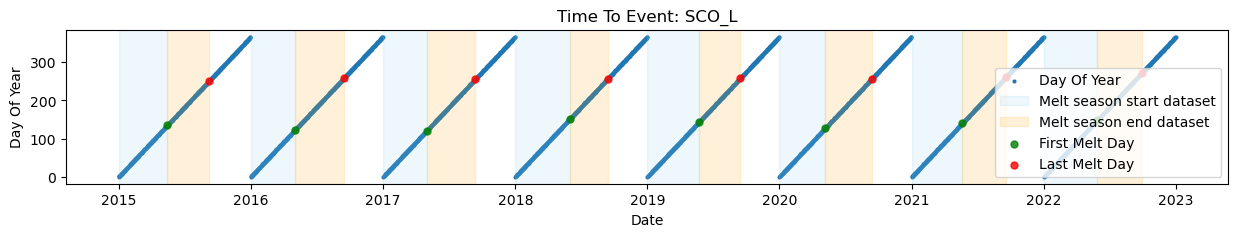

In [5]:
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

def period_viz(df, station, date_range=None):
    df_stat = df.loc[df['stid'] == station]
    max_year, min_year = df_stat['Year'].max(), df_stat['Year'].min()
    df_stat = df_stat.loc[(df_stat['Year'] >= 2015) & (df_stat['Year'] <= 2022)]
    years = df_stat['Year'].unique()
    melt_season_start_dates, melt_season_end_dates, first_day_of_year = [], [], []

    for year in years:
        df_year = df_stat.loc[df_stat['Year'] == year]

        melt_season_start_dates.append(df_year.loc[df_year['Ablation'] == True]['Datetime'].min())
        melt_season_end_dates.append(df_year.loc[df_year['Ablation'] == True]['Datetime'].max())
        first_day_of_year.append(df_year.loc[df_year['DayOfYear'] == 1]['Datetime'].max())

    fig, ax = plt.subplots(figsize=(15, 2))

    # Plot the blue scatter points
    plt.scatter(df_stat['Datetime'], df_stat['DayOfYear'], c='C0', marker='.', label='Day Of Year', s=15)

    for first_day, last_day in zip(first_day_of_year, melt_season_start_dates):
        ax.axvspan(first_day, last_day, alpha=0.15, color='skyblue', label='Melt season start dataset' if first_day == first_day_of_year[0] else "")

    for first_day, last_day in zip(melt_season_start_dates, melt_season_end_dates):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange', label='Melt season end dataset' if first_day == melt_season_start_dates[0] else "")

    # Plot the first melt day values
    plt.scatter(melt_season_start_dates, df_stat.loc[df_stat['Datetime'].isin(melt_season_start_dates), 'DayOfYear'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)

    # Plot the last melt day values
    plt.scatter(melt_season_end_dates, df_stat.loc[df_stat['Datetime'].isin(melt_season_end_dates), 'DayOfYear'], c='r', alpha=0.8, marker='.', label='Last Melt Day', s=100)

    # set plot title, axis labels and legend
    ax.set_title(f'Time To Event: {station}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Day Of Year')
    ax.legend(loc='lower right')


    if date_range:
        ax.set_xlim(date_range)

    years_fmt = mdates.YearLocator()
    ax.xaxis.set_major_locator(years_fmt)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Save the plot in the Downloads folder
    # plot_filename = f'Surface_Height_{stid}.png'
    # plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)

    plt.show()

# Set the datetime range to display by passing the date_range argument as a tuple (start_date, end_date)
# For example: date_range=('2010-01-01', '2020-12-31')
period_viz(data, 'SCO_L', date_range=None)


## Preprocessing Function

In [6]:

import warnings
import pandas as pd

def create_lagged_features(df, lags_in_days):
    # This function creates lagged features according to lags_in_days
    lagged_cols = []

    # Iterate over each column in the DataFrame.
    for column in df.columns:
        # For each column, create len(lags_in_days) new columns with lagged values.
        for lag in lags_in_days:
            lagged_cols.append(df[column].shift(lag).rename(f'{column}_lag_{lag}_days'))
            
    # Use pd.concat to join all the lagged columns together.
    lagged_df = pd.concat(lagged_cols, axis=1)
    
    # Make a copy of the DataFrame to de-fragment it.
    lagged_df = lagged_df.copy()
    
    return lagged_df


def preprocessing_melt(data, start_end='start', lags=False, exclude_nan=False):
    """
    This function performs preprocessing including feature creation, scaling and encoding.

    Parameters:
    - data: dataframe to preprocess
    - start_end: 'start' to preprocess start of the ablation event, 'end' for the end
    - lags: int number of lags to include as features, or False to exclude
    - exclude_nan: boolean whether to exclude rows with NaN values

    Returns:
    - df: the original dataframe with added features and scaled columns
    - features: the processed feature matrix
    - target: the processed target matrix
    """
    
    # Copy original dataframe to avoid mutation
    df = data.copy()
    df['Albedo'] = df['Albedo'].bfill()

    # Initialize event columns
    df['event'] = 0
    df['event_True'] = 0
    df.loc[:,'event_True'] = True
    df['time_to_event'] = 0

    # Create cyclical features for the wind direction
    cyclical = CyclicalFeatures(variables=None, drop_original=True)
    df_wind = df[df['Wind from direction (upper boom)'].notna()] 
    cyclical_df = cyclical.fit_transform(df_wind[['Wind from direction (upper boom)']]) 
    df = df.merge(cyclical_df, how='left',left_index=True,right_index=True)
    df.drop('Wind from direction (upper boom)', axis=1, inplace=True)

    # Perform min/max scaling on numerical features
    columns_to_drop = ['stid','Datetime','Ablation','Melting Season','Year','time_to_event', 
                       'DayOfYear', 'event', 'event_True', 'DayOfYear', 'Wind from direction (upper boom)_cos', 
                       'Wind from direction (upper boom)_sin', 'Month']
    train_columns = df.drop(columns_to_drop, axis=1).columns
    scaler = MinMaxScaler()
    df[train_columns] = scaler.fit_transform(df[train_columns])
    train_columns = train_columns.append(df[['Wind from direction (upper boom)_cos', 'Wind from direction (upper boom)_sin']].columns)

    # Create lagged features if lags is not False
    if type(lags) == list:
        lagged_features = create_lagged_features(df[train_columns], lags)
        features = pd.merge(df[train_columns], lagged_features, how='left', left_index=True, right_index=True)
        #display(features)
    elif not lags:
        features = df[train_columns].copy()
    else:
        raise ValueError('Lags input not accepted, needs to be False or int')

    # Encode categorical variables
    label_encoder = LabelEncoder()
    label_df = pd.DataFrame()
    label_df.index = df.index.copy()
    label_df['station_encoded'], label_df['year_encoded'] = label_encoder.fit_transform(df['stid']), label_encoder.fit_transform(df['Year'])
    features['year_encoded'], features['station_encoded'] = label_df['year_encoded'], label_df['station_encoded']

    # Calculate event date and time to event per year
    for station in df['stid'].unique():
        unique_years = df.loc[df['stid'] == station,'Year'].unique()
        #print(unique_years)
        for year in unique_years:
            # Filter data for the current year
            year_data = df[(df['stid'] == station) & (df['Year'] == year)]

            # Define the event date depending on start_end parameter
            if start_end == 'start':
                event = year_data.loc[year_data['Ablation'] == True]['Datetime'].min()     
            elif start_end == 'end':
                event = year_data.loc[year_data['Ablation'] == True]['Datetime'].max()

            # Update the event and time_to_event columns in the original DataFrame
            df.loc[(df['stid'] == station) & (df['Datetime'] == event), ['event']] = 1
            df.loc[(df['Year'] == year) & (df['stid'] == station), ['time_to_event']] = (event - year_data['Datetime']).astype('timedelta64[D]')

    # Filter the dataframe according to the start_end parameter
    if start_end == 'start':
        df = df.loc[df['time_to_event'] >= 0]
    elif start_end == 'end':
        df = df.loc[df['Ablation'] == True]

    # Drop NaN values if exclude_nan is True
    nan_features = features.drop(['Albedo','year_encoded','station_encoded'],axis=1)
    nan_features.dropna(how='all', inplace = True)
    df = df.loc[df.index.intersection(nan_features.index)]

    # Define the target DataFrame
    target = df[['event', 'event_True', 'time_to_event']].copy()
    target.dropna(inplace=True)
    
    # excluding NaN values
    if exclude_nan:
        features.dropna(inplace=True)
        df = df.loc[df.index.intersection(features.index)]
    
    # Ensure that all dataframes have the same index
    common_index = df.index.intersection(target.index)
    df, target, features = df.loc[common_index], target.loc[common_index], features.loc[common_index]

    return df, features, target

df, features, target = preprocessing_melt(data, start_end='start',lags=[3, 7, 14], exclude_nan=False)
display(features.head(5))
print(df['Year'].max())
print(df['Year'].min())



Air pressure (upper boom)  Air temperature (upper boom)  \
57469                   0.764231                      0.654537   
57470                   0.761145                      0.726834   
57471                   0.763148                      0.666208   
57472                   0.757517                      0.540154   
57473                   0.746657                      0.624130   

       Relative humidity (upper boom) - corrected  \
57469                                    0.614515   
57470                                    0.622504   
57471                                    0.787592   
57472                                    0.961577   
57473                                    0.832187   

       Specific humidity (upper boom)  Wind speed (upper boom)  \
57469                        0.233504                 0.243069   
57470                        0.326606                 0.168660   
57471                        0.314023                 0.067563   
57472                        0.218582                 0.039709   
57473                        0.280022                 0.126619   

       Downwelling shortwave radiation - corrected  \
57469                                     0.001373   
57470                                     0.001570   
57471                                     0.001672   
57472                                     0.001304   
57473                                     0.001473   

       Upwelling shortwave radiation - corrected  \
57469                                   0.001324   
57470                                   0.001510   
57471                                   0.001604   
57472                                   0.001248   
57473                                   0.001407   

       Downwelling longwave radiation  Upwelling longwave radiation  \
57469                        0.350316                      0.583373   
57470                        0.405676                      0.617943   
57471                        0.423826                      0.591702   
57472                        0.415749                      0.542649   
57473                        0.401086                      0.577472   

       Surface temperature  ...  Cloud cover_lag_7_days  \
57469             0.888389  ...                0.312583   
57470             0.926354  ...                0.590417   
57471             0.895097  ...                0.538542   
57472             0.836354  ...                0.898292   
57473             0.879032  ...                0.193083   

       Cloud cover_lag_14_days  \
57469                 0.465375   
57470                 0.294625   
57471                 0.360250   
57472                 0.909708   
57473                 0.978250   

       Wind from direction (upper boom)_cos_lag_3_days  \
57469                                        -0.496090   
57470                                        -0.798920   
57471                                        -0.617618   
57472                                        -0.833920   
57473                                        -0.751856   

       Wind from direction (upper boom)_cos_lag_7_days  \
57469                                        -0.826481   
57470                                        -0.805476   
57471                                        -0.965237   
57472                                        -0.565328   
57473                                        -0.496090   

       Wind from direction (upper boom)_cos_lag_14_days  \
57469                                         -0.511762   
57470                                         -0.572361   
57471                                         -0.655067   
57472                                         -0.466654   
57473                                         -0.395907   

       Wind from direction (upper boom)_sin_lag_3_days  \
57469                                         0.868271   
57470                                         0.601437   
57471                                     

2022
2007


In [7]:
def custom_train_test_split(df, features, target, method = 'by_year'):
    """
    Splits data into train and test sets by station.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    features (pd.DataFrame): The DataFrame containing feature data.
    target (pd.DataFrame): The DataFrame containing target data.

    Returns:
    X_train, X_test, y_train, y_test (pd.DataFrame): Train and test DataFrames for features and target, respectively.
    """

    if method == 'by_year':

        unique_years = df['Year'].unique()
        #print(list(unique_years))

        #train_years, test_years = train_test_split(unique_years, test_size=0.2, random_state=2023)
        
        test_years = [2020, 2021, 2022]
        train_years = [x for x in unique_years if x not in test_years]
        
        train = df.loc[df['Year'].isin(train_years)].index
        test = df.loc[df['Year'].isin(test_years)].index
        X_train = features.loc[features.index.isin(train)].copy()
        y_train = target.loc[target.index.isin(train)].copy()
        X_test = features.loc[features.index.isin(test)].copy()
        y_test = target.loc[features.index.isin(test)].copy()
    
    elif method == 'standard_train_test':
        stid_values = df['stid'].unique()
        X_train, X_test, y_train, y_test = [], [], [], []

        for stid in stid_values:
            feature_station = features.loc[df.loc[df['stid'] == stid].index]
            target_station = target.loc[df.loc[df['stid'] == stid].index]

            X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
            feature_station, target_station, test_size=0.3, random_state=123, shuffle=True)

            X_train.append(X_train_subset)
            X_test.append(X_test_subset)
            y_train.append(y_train_subset)
            y_test.append(y_test_subset)

        X_train = pd.concat(X_train)
        X_test = pd.concat(X_test)
        y_train = pd.concat(y_train)
        y_test = pd.concat(y_test)
    
    else:
        raise ValueError('method must be by_year or standard_train_test')

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, method= 'by_year')
print(len(df))
print(len(X_train), len(X_test))


27016
20978 6038


In [12]:
list(features.index) == list(target.index)

True

## Visualization Functions

In [13]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_absolute_error, greater_is_better=False))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt


def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    for ii, (tr, tt) in enumerate(cv.split(X, y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + 0.5] * len(indices), c=indices, marker="_", lw=lw, cmap=plt.cm.coolwarm, vmin=-0.2, vmax=1.2)

    ax.set_xlabel("Sample index")
    ax.set_ylabel("CV iteration")
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.set_title("{}".format(type(cv).__name__))
    return ax

def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=None, n_jobs=-1, log_scale=False):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(f"{param_name}")
    plt.ylabel("Score")
    plt.grid()

    if log_scale:
        plt.xscale("log")

    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    #return plt

def station_performance_viz(df, X_train, X_test, y_train, y_test, label, model):
    station_names = df['stid'].unique()
    print(station_names)

    for station in station_names:
        print('------------------------------------------------------------------------------------')
        print('station_names', station)

        # Subset X_train and X_test with the values of station_names
        X_train_station = X_train.loc[df['stid'] == station]
        X_test_station = X_test.loc[df['stid'] == station]

        # Subset y_train and y_test with the indices of X_train_station and X_test_station
        y_train_station = y_train.loc[X_train_station.index]
        y_test_station = y_test.loc[X_test_station.index]

        y_pred_station = model.predict(X_test_station)
      
        r2_station = r2_score(y_test_station, y_pred_station)
        mse_station = mean_squared_error(y_test_station, y_pred_station, squared=False)
        mae_station = mean_absolute_error(y_test_station, y_pred_station)
        print('Number of observations at station', len(y_test_station))
        
        print("R^2 score on test set: ", r2_station)
        print("MSE on test set: ", mse_station)
        print("MAE on test set", mae_station)

        # ----------------------------------------------------------------------------------------------
        y_result = pd.DataFrame(y_test_station)
        y_result['DayOfYear'] = df['DayOfYear']
        y_result['pred'] = y_pred_station
        y_result['Monthly Pred Mean'] = y_result['pred'] + y_result['DayOfYear']
        
        y_result['Datetime'] = df['Datetime']
        y_result['Datetime'] = pd.to_datetime(y_result['Datetime'])
        y_result.set_index('Datetime',inplace=True)
        y_result['month'] = y_result.index.month
        y_result['year'] = y_result.index.year
        y_result['Running Pred Mean'] = y_result.groupby('year')['Monthly Pred Mean'].expanding().mean().reset_index(level=0, drop=True)
        y_result['Actual Event Date'] = np.where(y_result['time_to_event'] == 0, y_result['DayOfYear'], np.nan)
        y_result['Actual Event Date'] = y_result['Actual Event Date'].bfill()

        monthly_average = y_result.groupby(['year', 'month']).agg({'Monthly Pred Mean':'mean','Running Pred Mean':'last','Actual Event Date':'mean'})#.reset_index()
        
        monthly_average[''] = '|'
        monthly_average['Monthly Pred Mean Diff'] = monthly_average['Monthly Pred Mean'] - monthly_average['Actual Event Date']
        monthly_average['Running Pred Mean Diff'] = monthly_average['Running Pred Mean'] - monthly_average['Actual Event Date']
        
        num_cols = [
            'Monthly Pred Mean',
            'Running Pred Mean',
            'Actual Event Date',
            'Monthly Pred Mean Diff',
            'Running Pred Mean Diff'
        ]

        monthly_average[num_cols] = monthly_average[num_cols].round().applymap('{:.0f}'.format)
        display(monthly_average)

        # ---------------------------------------------------------------------------------------------

        plt.figure(figsize=(25, 3))
        plt.scatter(df.loc[X_test_station.index,'Datetime'], y_test_station, label="True evaluation values", alpha=0.8, s=20)
        plt.scatter(df.loc[X_test_station.index,'Datetime'], y_pred_station, label="Predicted evaluation values", alpha = 0.8, s=20)
      
        plt.xlabel("Time")
        
        plt.ylabel("Target")
        plt.title(f"{station}: {label} Predictions vs True Test Values")
        plt.legend()
        plt.show()
    #return plt

def station_performance_sum(df, X_train, X_test, y_train, y_test, label, model):
    station_names = df['stid'].unique()
    #print(station_names)
    stations_in = ['KAN_L', 'SCO_L','QAS_L']
   # stations_in = ['SCO_L']
    station_names = [x for x in station_names if x in stations_in]
    for station in station_names:
        print('------------------------------------------------------------------------------------')
        print('station_names', station)

        # Subset X_train and X_test with the values of station_names
        X_train_station = X_train.loc[df['stid'] == station]
        X_test_station = X_test.loc[df['stid'] == station]

        # Subset y_train and y_test with the indices of X_train_station and X_test_station
        y_train_station = y_train.loc[X_train_station.index]
        y_test_station = y_test.loc[X_test_station.index]
        

        y_pred_station = model.predict(X_test_station)

        y_result = pd.DataFrame(y_test_station)


        #y_train_station['Datetime'] = df['Datetime']
        #y_test_station['Datetime'] = df['Datetime']
        y_result['DayOfYear'] = df['DayOfYear']
        y_result['pred'] = y_pred_station
        y_result['Monthly Pred Mean'] = y_result['pred'] + y_result['DayOfYear']
        
        y_result['Datetime'] = df['Datetime']
        y_result['Datetime'] = pd.to_datetime(y_result['Datetime'])
        y_result.set_index('Datetime',inplace=True)
        y_result['month'] = y_result.index.month
        y_result['year'] = y_result.index.year
        y_result['Running Pred Mean'] = y_result.groupby('year')['Monthly Pred Mean'].expanding().mean().reset_index(level=0, drop=True)
        y_result['Actual Event Date'] = np.where(y_result['time_to_event'] == 0, y_result['DayOfYear'], np.nan)
        y_result['Actual Event Date'] = y_result['Actual Event Date'].bfill()
        
        


        monthly_average = y_result.groupby(['year', 'month']).agg({'Monthly Pred Mean':'mean','Running Pred Mean':'last','Actual Event Date':'mean'})#.reset_index()
        
        monthly_average[''] = '|'
        monthly_average['Monthly Pred Mean Diff'] = monthly_average['Monthly Pred Mean'] - monthly_average['Actual Event Date']
        monthly_average['Running Pred Mean Diff'] = monthly_average['Running Pred Mean'] - monthly_average['Actual Event Date']
        
        num_cols = [
            'Monthly Pred Mean',
            'Running Pred Mean',
            'Actual Event Date',
            'Monthly Pred Mean Diff',
            'Running Pred Mean Diff'
        ]

        monthly_average[num_cols] = monthly_average[num_cols].round().applymap('{:.0f}'.format)
        
         
       


        #monthly_average['Actual'] = 
        
        
        #groupby('month')['pred_translated'].mean()
        #print(type(monthly_average))
        display(monthly_average)
        #display(y_result)
        
      

#station_performance_sum(df, X_train, X_test, y_train, y_test, 'XGBoost Regressor', xgb_model)



        


# Modelling

-------------------------------------------------------

In [48]:
# Gridsearch cross validation definition
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=123)

# Data Preprocessing
df, features, target = preprocessing_melt(data, start_end='start',lags=False, exclude_nan=False)
X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, method='by_year')
#X_train.drop('year_encoded', axis=1, inplace=True)
#X_test.drop('year_encoded', axis=1, inplace=True)
X_train['DayOfYear'] = df['DayOfYear']
X_test['DayOfYear'] = df['DayOfYear']
X_train['Month'] = df['Month']
X_test['Month'] = df['Month']
y_train = y_train['time_to_event']
y_test = y_test['time_to_event']


In [49]:
def custom_time_series_cv(df_testerino):
    unique_stations = df_testerino['station_encoded'].unique()
    unique_years = df_testerino['station_encoded'].unique()

    n_splits = len(unique_years) - 1  # one less split than number of years

    for i in range(n_splits):
        train_indices = df_testerino[(df_testerino['station_encoded'].isin(unique_stations)) & (df_testerino['year_encoded'] <= unique_years[i])].index
        test_indices = df_testerino[(df_testerino['station_encoded'].isin(unique_stations)) & (df_testerino['year_encoded'] == unique_years[i + 1])].index
        #display(X_train.loc[train_indices]['year_encoded'].unique())
        #display(X_train.loc[test_indices]['year_encoded'].unique())
        yield train_indices, test_indices

#df_index = df.loc[X_train.index]
#X_train.reset_index(drop=True,inplace=True)
#y_train.reset_index(drop=True,inplace=True)

        

## XGBoost Regression

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.5}
Best hyperparameters:  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.5}
------------------------------------------------------------------------------------
Average MAE test score from cv : 0.9666164053504056
Standard deviation of MAE test scores from cv: 0.0007827046193356849
------------------------------------------------------------------------------------
MAE on validation set:  19.885644937835774
R^2 score on validation set:  0.7358621379603294


['KAN_L' 'KPC_L' 'MIT' 'NUK_L' 'NUK_U' 'QAS_L' 'QAS_U' 'SCO_L' 'SCO_U'
 'TAS_L' 'THU_L' 'UPE_L' 'UPE_U']
------------------------------------------------------------------------------------
station_names KAN_L
Number of observations at station 393
R^2 score on test set:  0.8688382341034216
MSE on test set:  14.139234094306142
MAE on test set 12.315466876400032


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 1                   131               131               122  |   
     2                   137               134               122  |   
     3                   135               134               122  |   
     4                   134               134               122  |   
     5                   133               134               122  |   
2021 1                   130               130               121  |   
     2                   129               130               121  |   
     3                   130               130               121  |   
     4                   132               130               121  |   
     5                   133               130               121  |   
2022 1                   134               134               150  |   
     2                   134               134               150  |   
     3                   137               135               150  |   
     4                   129               134               150  |   
     5                   144               136               150  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 1                          9                      9  
     2                         15                     12  
     3                         13                     12  
     4                         12                     12  
     5                         11                     12  
2021 1                          9                      9  
     2                          8                      9  
     3                          9                      9  
     4                         11                      9  
     5                         12                      9  
2022 1                        -16                    -16  
     2                        -16                    -16  
     3                        -13                    -15  
     4                        -21                    -16  
     5                         -6                    -14

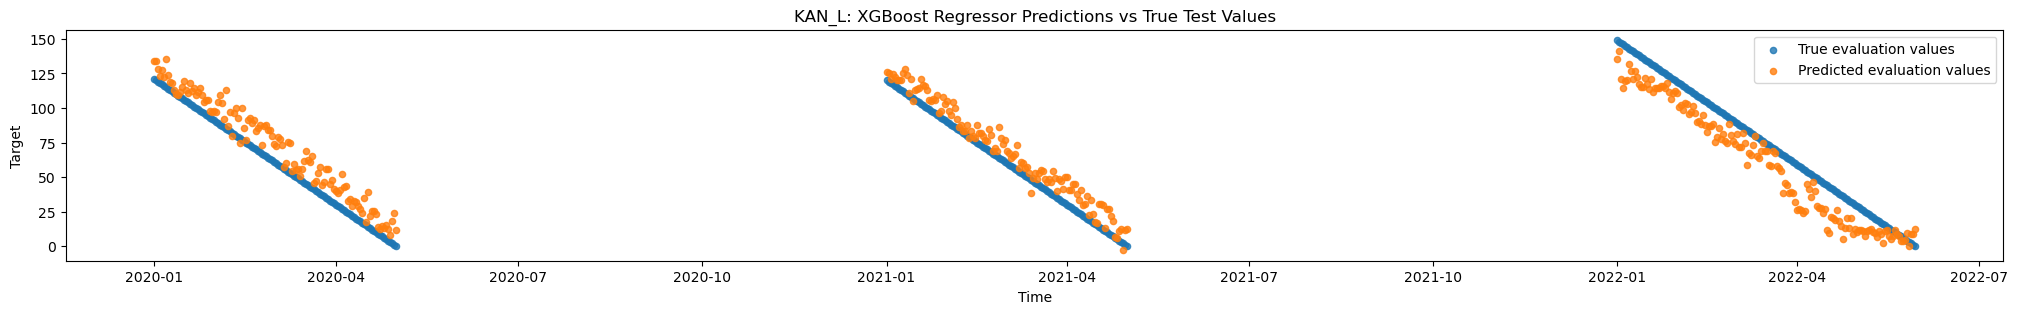

------------------------------------------------------------------------------------
station_names KPC_L
Number of observations at station 457
R^2 score on test set:  0.8017479421237286
MSE on test set:  19.5801633960854
MAE on test set 18.167252975689244


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 1                   175               175               153  |   
     2                   173               174               153  |   
     3                   174               174               153  |   
     4                   168               172               153  |   
     5                   161               170               153  |   
     6                   162               170               153  |   
2021 1                   173               173               152  |   
     2                   171               172               152  |   
     3                   175               173               152  |   
     4                   171               173               152  |   
     5                   160               170               152  |   
     6                   163               170               152  |   
2022 1                   174               174               152  |   
     2                   174               174               152  |   
     3                   174               174               152  |   
     4                   174               174               152  |   
     5                   162               171               152  |   
     6                   163               171               152  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 1                         22                     22  
     2                         20                     21  
     3                         21                     21  
     4                         15                     19  
     5                          8                     17  
     6                          9                     17  
2021 1                         21                     21  
     2                         19                     20  
     3                         23                     21  
     4                         19                     21  
     5                          8                     18  
     6                         11                     18  
2022 1                         22                     22  
     2                         22                     22  
     3                         22                     22  
     4                         22                     22  
     5                         10                     19  
     6                         11                     19

------------------------------------------------------------------------------------
station_names MIT
Number of observations at station 483
R^2 score on test set:  0.31458272374917473
MSE on test set:  43.522527349837915
MAE on test set 39.388612908112584


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 1                   177               177               131  |   
     2                   188               182               131  |   
     3                   180               181               131  |   
     4                   176               180               131  |   
     5                   194               181               131  |   
2021 1                   194               194               144  |   
     2                   200               197               144  |   
     3                   195               196               144  |   
     4                   200               197               144  |   
     5                   192               196               144  |   
2022 1                   169               169               208  |   
     2                   171               170               208  |   
     3                   186               176               208  |   
     4                   177               176               208  |   
     5                   189               178               208  |   
     6                   201               182               208  |   
     7                   214               186               208  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 1                         46                     46  
     2                         57                     51  
     3                         49                     50  
     4                         45                     49  
     5                         63                     50  
2021 1                         50                     50  
     2                         56                     53  
     3                         51                     52  
     4                         56                     53  
     5                         48                     52  
2022 1                        -39                    -39  
     2                        -37                    -38  
     3                        -22                    -32  
     4                        -31                    -32  
     5                        -19                    -30  
     6                         -7                    -26  
     7                          6                    -22

------------------------------------------------------------------------------------
station_names NUK_L
Number of observations at station 380
R^2 score on test set:  0.8900158302232659
MSE on test set:  12.228180253044126
MAE on test set 10.166559952419055


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 1                   125               125               136  |   
     2                   130               127               136  |   
     3                   133               129               136  |   
     4                   132               130               136  |   
     5                   141               131               136  |   
2021 1                   129               129               121  |   
     2                   132               130               121  |   
     3                   132               131               121  |   
     4                   134               132               121  |   
     5                   120               132               121  |   
2022 1                   124               124               123  |   
     2                   135               129               123  |   
     3                   136               132               123  |   
     4                   140               134               123  |   
     5                   154               134               123  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 1                        -11                    -11  
     2                         -6                     -9  
     3                         -3                     -7  
     4                         -4                     -6  
     5                          5                     -5  
2021 1                          8                      8  
     2                         11                      9  
     3                         11                     10  
     4                         13                     11  
     5                         -1                     11  
2022 1                          1                      1  
     2                         12                      6  
     3                         13                      9  
     4                         17                     11  
     5                         31                     11

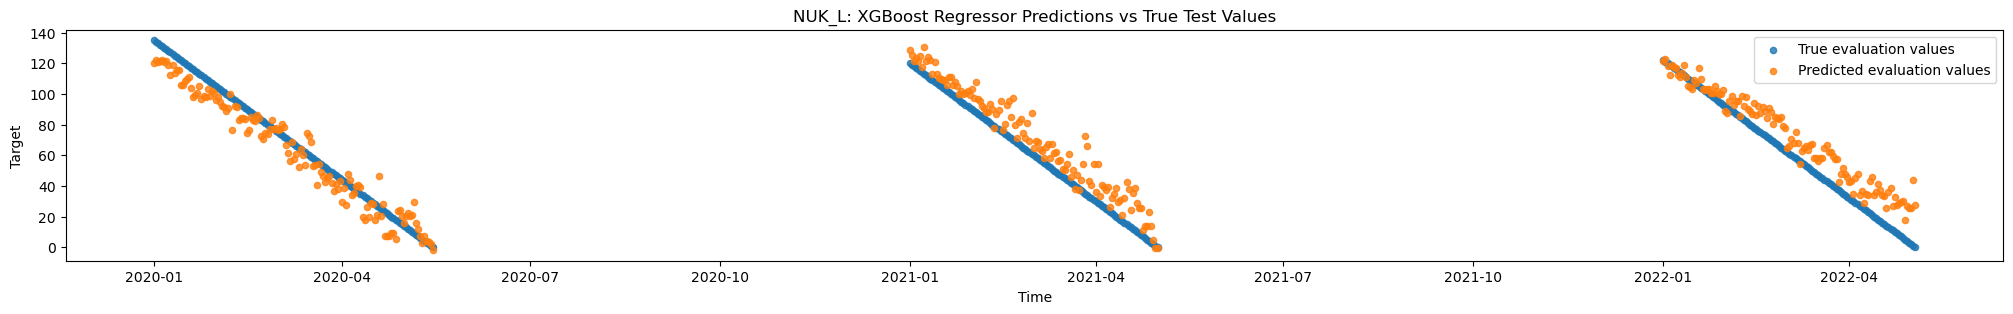

------------------------------------------------------------------------------------
station_names NUK_U
Number of observations at station 561
R^2 score on test set:  0.44685728677370273
MSE on test set:  40.28989998194648
MAE on test set 36.4209352238718


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 1                   137               137               182  |   
     2                   134               136               182  |   
     3                   146               139               182  |   
     4                   144               140               182  |   
     5                   161               144               182  |   
     6                   181               151               182  |   
2021 1                   137               137               196  |   
     2                   138               138               196  |   
     3                   146               140               196  |   
     4                   143               141               196  |   
     5                   150               143               196  |   
     6                   175               148               196  |   
     7                   199               152               196  |   
2022 1                   143               143               183  |   
     2                   145               144               183  |   
     3                   148               145               183  |   
     4                   140               144               183  |   
     5                   157               147               183  |   
     6                   188               154               183  |   
     7                   193               154               183  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 1                        -45                    -45  
     2                        -48                    -46  
     3                        -36                    -43  
     4                        -38                    -42  
     5                        -21                    -38  
     6                         -1                    -31  
2021 1                        -59                    -59  
     2                        -58                    -58  
     3                        -50                    -56  
     4                        -53                    -55  
     5                        -46                    -53  
     6                        -21                    -48  
     7                          3                    -44  
2022 1                        -40                    -40  
     2                        -38                    -39  
     3                        -35                    -38  
     4                        -43                    -39  
     5                        -26                    -36  
     6                          5                    -29  
     7                         10                    -29

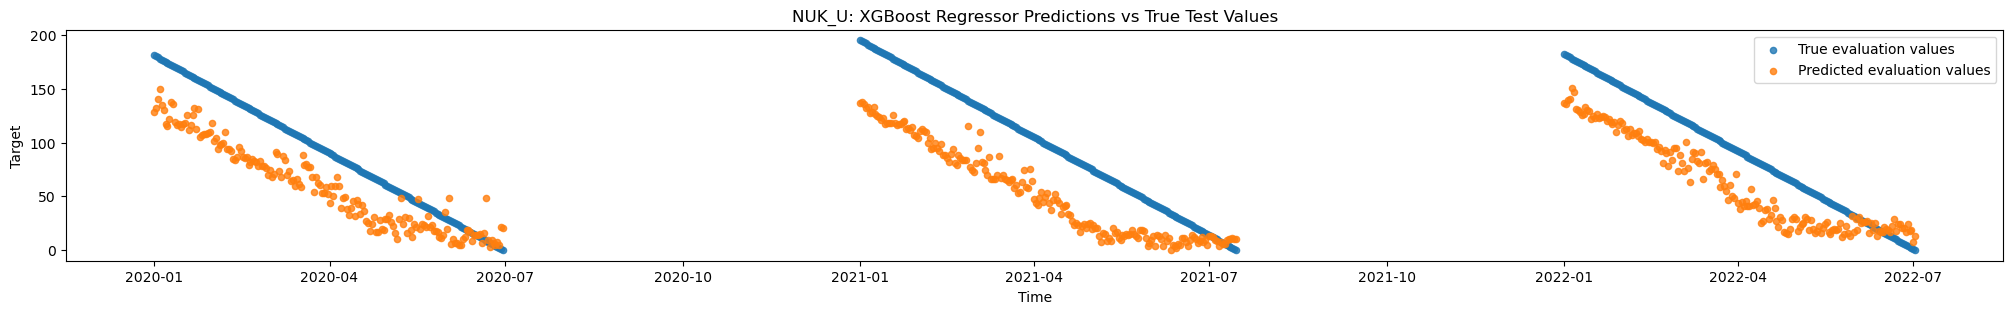

------------------------------------------------------------------------------------
station_names QAS_L
Number of observations at station 435
R^2 score on test set:  0.9285047145664043
MSE on test set:  11.269839347872493
MAE on test set 9.255812268969656


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 1                   144               144               137  |   
     2                   138               141               137  |   
     3                   140               141               137  |   
     4                   145               142               137  |   
     5                   149               143               137  |   
2021 1                   146               146               154  |   
     2                   146               146               154  |   
     3                   141               144               154  |   
     4                   136               142               154  |   
     5                   153               144               154  |   
     6                   162               145               154  |   
2022 1                   155               155               144  |   
     2                   146               150               144  |   
     3                   145               149               144  |   
     4                   136               145               144  |   
     5                   151               146               144  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 1                          7                      7  
     2                          1                      4  
     3                          3                      4  
     4                          8                      5  
     5                         12                      6  
2021 1                         -8                     -8  
     2                         -8                     -8  
     3                        -13                    -10  
     4                        -18                    -12  
     5                         -1                    -10  
     6                          8                     -9  
2022 1                         11                     11  
     2                          2                      6  
     3                          1                      5  
     4                         -8                      1  
     5                          7                      2

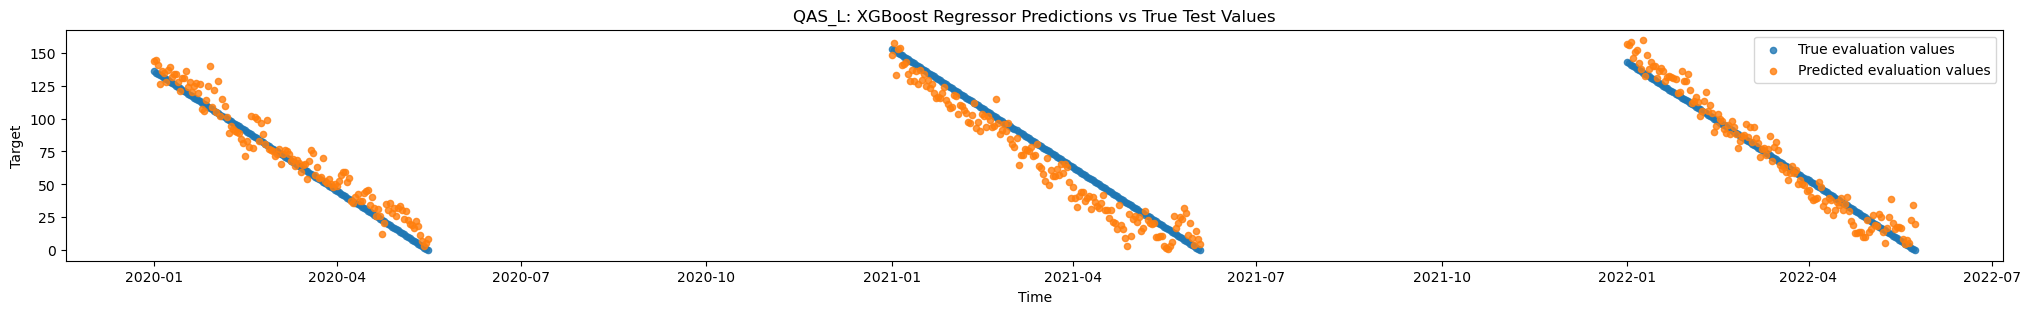

------------------------------------------------------------------------------------
station_names QAS_U
Number of observations at station 407
R^2 score on test set:  0.7396538065009038
MSE on test set:  31.142369942477046
MAE on test set 26.622239140093473


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 1                   175               175               227  |   
     2                   182               178               227  |   
     3                   185               181               227  |   
     4                   181               181               227  |   
     5                   198               184               227  |   
     6                   204               187               227  |   
     7                   217               192               227  |   
     8                   231               194               227  |   
2022 1                   195               195               180  |   
     2                   194               195               180  |   
     3                   195               195               180  |   
     4                   203               197               180  |   
     5                   198               197               180  |   
     6                   202               198               180  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 1                        -52                    -52  
     2                        -45                    -49  
     3                        -42                    -46  
     4                        -46                    -46  
     5                        -29                    -43  
     6                        -23                    -40  
     7                        -10                    -35  
     8                          4                    -33  
2022 1                         15                     15  
     2                         14                     15  
     3                         15                     15  
     4                         23                     17  
     5                         18                     17  
     6                         22                     18

------------------------------------------------------------------------------------
station_names SCO_L
Number of observations at station 418
R^2 score on test set:  0.9330141535363423
MSE on test set:  10.528022682097191
MAE on test set 8.482070333649668


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 1                   135               135               128  |   
     2                   143               139               128  |   
     3                   144               141               128  |   
     4                   141               141               128  |   
     5                   148               141               128  |   
2021 1                   144               144               141  |   
     2                   147               145               141  |   
     3                   145               145               141  |   
     4                   142               144               141  |   
     5                   148               145               141  |   
2022 1                   154               154               149  |   
     2                   156               155               149  |   
     3                   151               153               149  |   
     4                   147               152               149  |   
     5                   151               152               149  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 1                          7                      7  
     2                         15                     11  
     3                         16                     13  
     4                         13                     13  
     5                         20                     13  
2021 1                          3                      3  
     2                          6                      4  
     3                          4                      4  
     4                          1                      3  
     5                          7                      4  
2022 1                          5                      5  
     2                          7                      6  
     3                          2                      4  
     4                         -2                      3  
     5                          2                      3

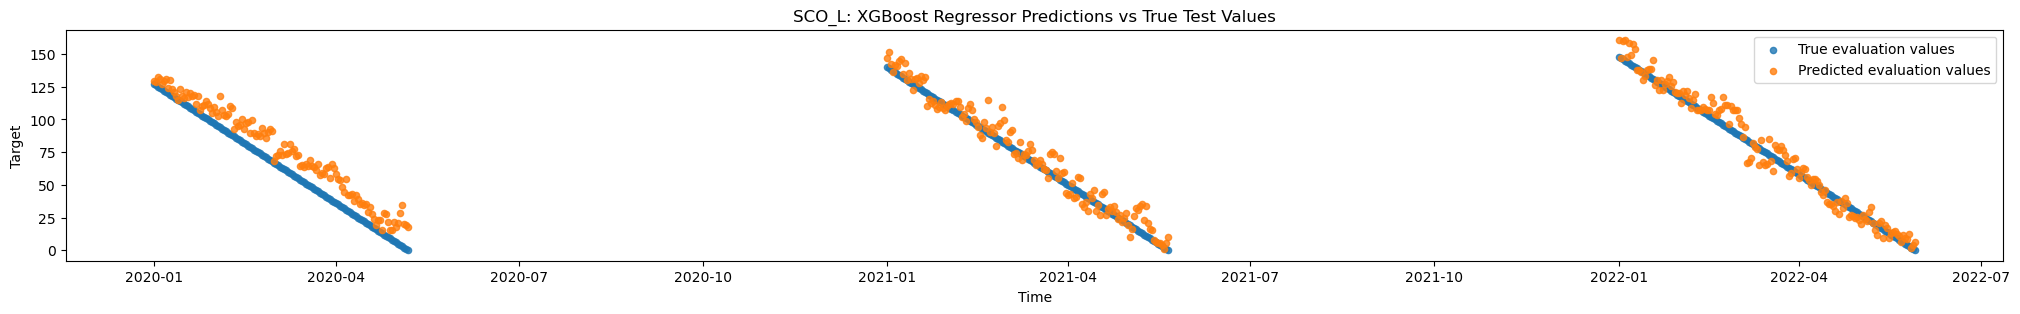

------------------------------------------------------------------------------------
station_names SCO_U
Number of observations at station 440
R^2 score on test set:  0.7390690673521096
MSE on test set:  22.630031973199166
MAE on test set 16.971723331104624


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 1                   168               168               153  |   
     2                   164               166               153  |   
     3                   164               165               153  |   
     4                   162               164               153  |   
     5                   160               164               153  |   
     6                   155               164               153  |   
2021 1                   162               162               121  |   
     2                   162               162               121  |   
     3                   161               162               121  |   
     4                   158               161               121  |   
     5                   157               161               121  |   
2022 1                   163               163               166  |   
     2                   158               160               166  |   
     3                   161               161               166  |   
     4                   157               160               166  |   
     5                   165               161               166  |   
     6                   172               162               166  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 1                         15                     15  
     2                         11                     13  
     3                         11                     12  
     4                          9                     11  
     5                          7                     11  
     6                          2                     11  
2021 1                         41                     41  
     2                         41                     41  
     3                         40                     41  
     4                         37                     40  
     5                         36                     40  
2022 1                         -3                     -3  
     2                         -8                     -6  
     3                         -5                     -5  
     4                         -9                     -6  
     5                         -1                     -5  
     6                          6                     -4

------------------------------------------------------------------------------------
station_names TAS_L
Number of observations at station 451
R^2 score on test set:  0.8544693872953377
MSE on test set:  16.91436679234849
MAE on test set 14.099125479515271


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 1                   146               146               157  |   
     2                   153               149               157  |   
     3                   140               146               157  |   
     4                   135               144               157  |   
     5                   142               143               157  |   
     6                   162               144               157  |   
2021 1                   154               154               162  |   
     2                   158               156               162  |   
     3                   147               153               162  |   
     4                   145               151               162  |   
     5                   157               152               162  |   
     6                   171               153               162  |   
2022 1                   137               137               132  |   
     2                   160               148               132  |   
     3                   157               151               132  |   
     4                   145               149               132  |   
     5                   154               150               132  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 1                        -11                    -11  
     2                         -4                     -8  
     3                        -17                    -11  
     4                        -22                    -13  
     5                        -15                    -14  
     6                          5                    -13  
2021 1                         -8                     -8  
     2                         -4                     -6  
     3                        -15                     -9  
     4                        -17                    -11  
     5                         -5                    -10  
     6                          9                     -9  
2022 1                          5                      5  
     2                         28                     16  
     3                         25                     19  
     4                         13                     17  
     5                         22                     18

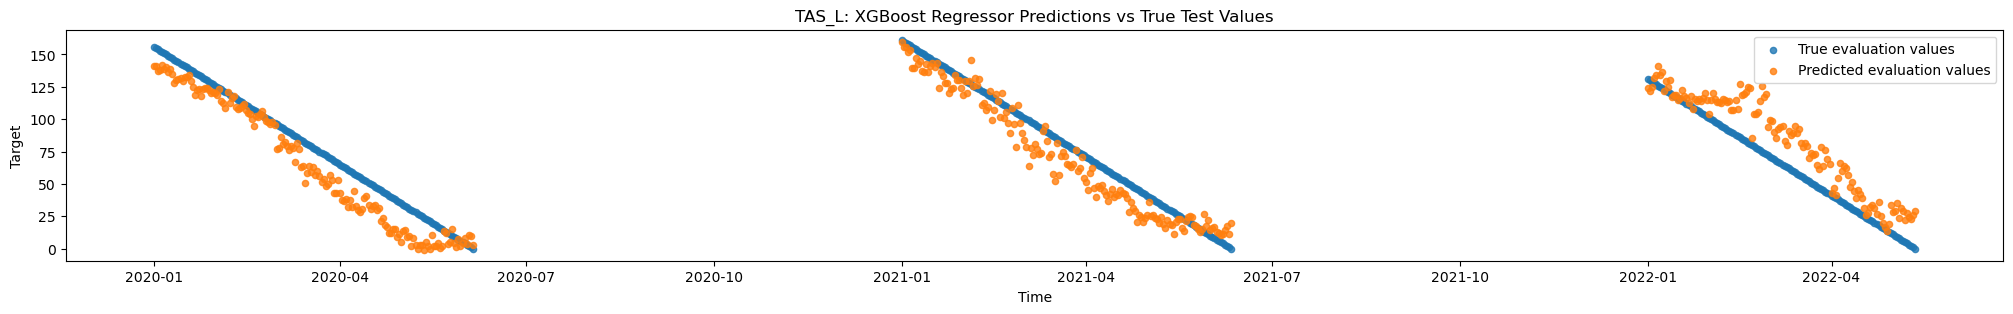

------------------------------------------------------------------------------------
station_names THU_L
Number of observations at station 578
R^2 score on test set:  0.7052605324197474
MSE on test set:  30.86734812571123
MAE on test set 24.506852294901663


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 1                   167               167               187  |   
     2                   163               165               187  |   
     3                   162               164               187  |   
     4                   165               164               187  |   
     5                   172               166               187  |   
     6                   186               169               187  |   
     7                   195               170               187  |   
2021 1                   153               153               214  |   
     2                   155               154               214  |   
     3                   161               156               214  |   
     4                   167               159               214  |   
     5                   173               162               214  |   
     6                   182               165               214  |   
     7                   207               171               214  |   
     8                   218               172               214  |   
2022 1                   170               170               179  |   
     2                   168               169               179  |   
     3                   165               168               179  |   
     4                   168               168               179  |   
     5                   172               169               179  |   
     6                   183               171               179  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 1                        -20                    -20  
     2                        -24                    -22  
     3                        -25                    -23  
     4                        -22                    -23  
     5                        -15                    -21  
     6                         -1                    -18  
     7                          8                    -17  
2021 1                        -61                    -61  
     2                        -59                    -60  
     3                        -53                    -58  
     4                        -47                    -55  
     5                        -41                    -52  
     6                        -32                    -49  
     7                         -7                    -43  
     8                          4                    -42  
2022 1                         -9                     -9  
     2                        -11                    -10  
     3                        -14                    -11  
     4                        -11                    -11  
     5                         -7                    -10  
     6                          4                     -8

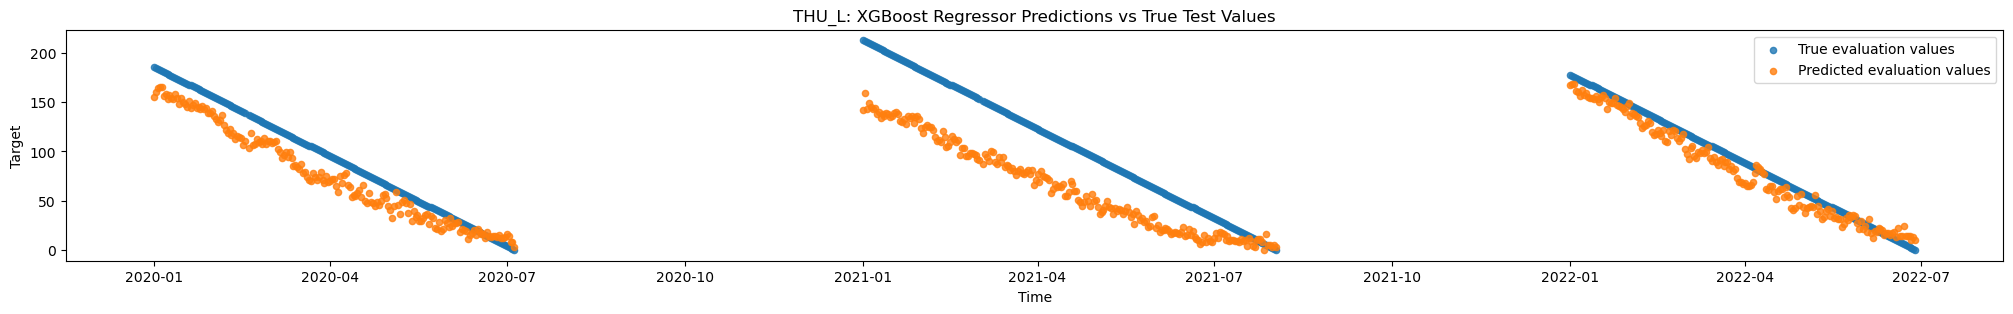

------------------------------------------------------------------------------------
station_names UPE_L
Number of observations at station 480
R^2 score on test set:  0.9155327669030549
MSE on test set:  13.572029309179847
MAE on test set 11.413994553188482


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 1                   154               154               167  |   
     2                   154               154               167  |   
     3                   151               153               167  |   
     4                   150               152               167  |   
     5                   155               153               167  |   
     6                   170               154               167  |   
2021 1                   143               143               146  |   
     2                   147               145               146  |   
     3                   143               144               146  |   
     4                   146               145               146  |   
     5                   150               146               146  |   
2022 1                   152               152               167  |   
     2                   155               153               167  |   
     3                   148               151               167  |   
     4                   146               150               167  |   
     5                   159               152               167  |   
     6                   172               154               167  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 1                        -13                    -13  
     2                        -13                    -13  
     3                        -16                    -14  
     4                        -17                    -15  
     5                        -12                    -14  
     6                          3                    -13  
2021 1                         -3                     -3  
     2                          1                     -1  
     3                         -3                     -2  
     4                         -0                     -1  
     5                          4                     -0  
2022 1                        -15                    -15  
     2                        -12                    -14  
     3                        -19                    -16  
     4                        -21                    -17  
     5                         -8                    -15  
     6                          5                    -13

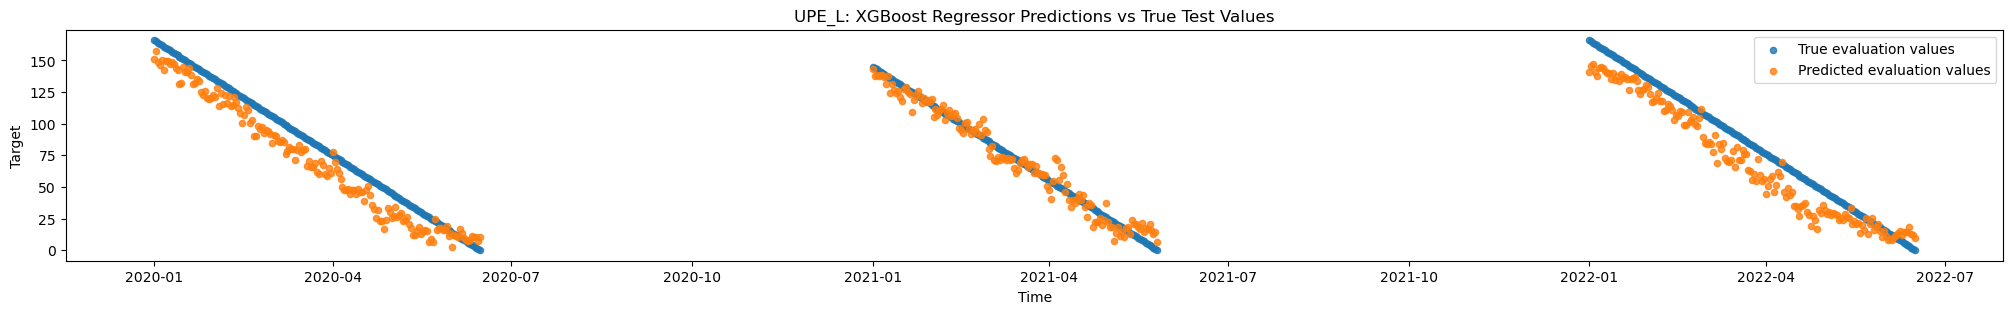

------------------------------------------------------------------------------------
station_names UPE_U
Number of observations at station 514
R^2 score on test set:  0.7854326422429507
MSE on test set:  25.38962951605467
MAE on test set 21.234796084318642


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 1                   162               162               199  |   
     2                   164               163               199  |   
     3                   161               162               199  |   
     4                   164               163               199  |   
     5                   167               164               199  |   
     6                   182               167               199  |   
     7                   202               170               199  |   
2021 1                   158               158               165  |   
     2                   162               160               165  |   
     3                   159               160               165  |   
     4                   162               160               165  |   
     5                   168               162               165  |   
     6                   177               164               165  |   
2022 1                   161               161               189  |   
     2                   158               160               189  |   
     3                   155               158               189  |   
     4                   160               159               189  |   
     5                   170               161               189  |   
     6                   184               165               189  |   
     7                   199               167               189  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 1                        -37                    -37  
     2                        -35                    -36  
     3                        -38                    -37  
     4                        -35                    -36  
     5                        -32                    -35  
     6                        -17                    -32  
     7                          3                    -29  
2021 1                         -7                     -7  
     2                         -3                     -5  
     3                         -6                     -5  
     4                         -3                     -5  
     5                          3                     -3  
     6                         12                     -1  
2022 1                        -28                    -28  
     2                        -31                    -29  
     3                        -34                    -31  
     4                        -29                    -30  
     5                        -19                    -28  
     6                         -5                    -24  
     7                         10                    -22

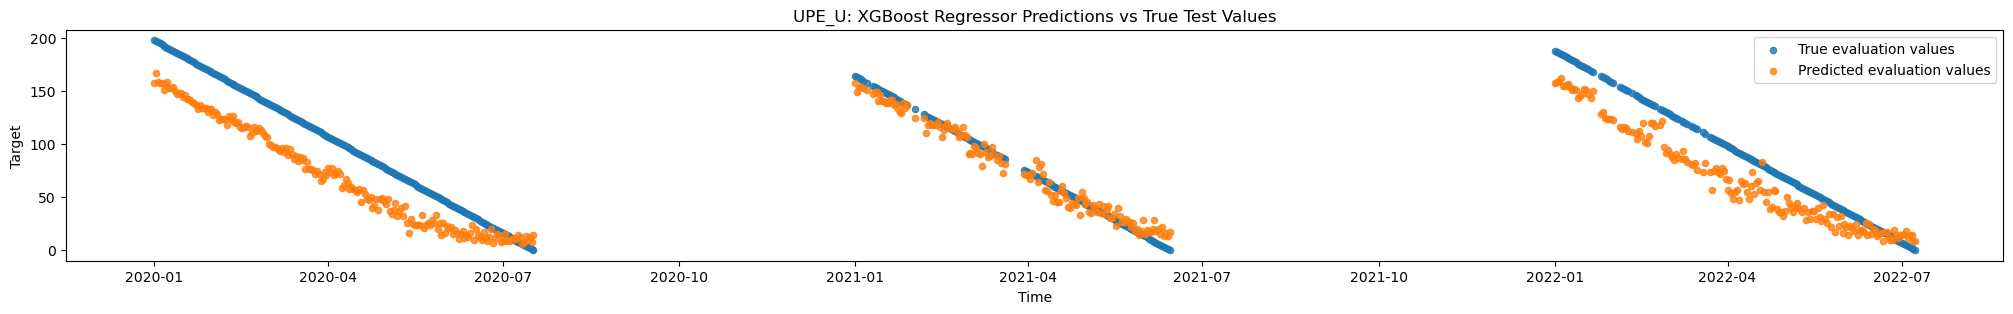

In [50]:
#cv = custom_time_series_cv(X_train)
#X_train.reset_index(drop=True,inplace=True)
#y_train.reset_index(drop=True,inplace=True)
# XGB Regressor
model = xgb.XGBRegressor()

param_grid ={
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15],
    'min_child_weight': [3, 5,  10], 
    'gamma': [0, 0.1, 0.5, 1], 
    'subsample': [0.5, 0.7, 1], 
    'colsample_bytree': [0.5, 0.7, 1]
}

param_grid ={
    'learning_rate': [0.01, 0.1],
    'max_depth': [5,  15],
    'min_child_weight': [3,  10], 
    'gamma': [0, 0.1,  1], 
    'subsample': [0.5, 1], 
    'colsample_bytree': [0.5, 1]
}



# Define the hyperparameter grid for tuning
param_grid ={
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_child_weight': [1, 2, 4, 6, 8, 10], 
    'gamma': [0, 0.1, 0.5, 0.7, 1], 
    'subsample': [0.5, 0.7, 0.8, 0.9, 1], 
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}



# paramgrid start
#param_grid = {
# 'colsample_bytree': [0.9], 'gamma': [0], 'learning_rate': [0.05], 'max_depth': [15], 'min_child_weight': [10], 'subsample': [0.8]
# }
#param_grid = {'colsample_bytree': [0.7], 'gamma': [0], 'learning_rate': [0.1], 'max_depth': [5], 'min_child_weight': [5], 'subsample': [0.5]}

#param_grid = {'colsample_bytree': [1], 'gamma': [1], 'learning_rate': [0.1], 'max_depth': [5], 'min_child_weight': [3], 'subsample': [1]}

# best for laggs
#{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.5}
#param_grid = {'colsample_bytree': [0.5], 'gamma': [0], 'learning_rate': [0.1], 'max_depth': [15], 'min_child_weight': [3], 'subsample': [0.5]}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=custom_time_series_cv(X_train), n_jobs=-1, verbose=5, scoring='neg_mean_absolute_error')

# custom_time_series_cv(X_train)
# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

# Print the best hyperparameters and the corresponding R^2 score on the test set

print(f"Best hyperparameters: ", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
# Save the best model parameters as 'model' variable
xgb_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred) 

print("Average MAE test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of MAE test scores from cv:", grid_search.cv_results_["std_test_score"][0])

mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_     

print('------------------------------------------------------------------------------------')
print(f'MAE on validation set: ', mae)
print(f"R^2 score on validation set: ", r2)
#print(f"MSE on validation set: ", mse)


plot_learning_curve(best_estimator, "Learning Curve (XGBRegressor)", X_train, y_train, cv=cv)


station_performance_viz(df, X_train, X_test, y_train, y_test, 'XGBoost Regressor', xgb_model)

In [34]:
print(grid_search.best_params_)

{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.5}


In [39]:
# Gridsearch cross validation definition
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=123)

# Data Preprocessing
df, features, target = preprocessing_melt(data, start_end='end',lags=[3, 7, 14], exclude_nan=False)
X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target, method='by_year')
#X_train.drop('year_encoded', axis=1, inplace=True)
#X_test.drop('year_encoded', axis=1, inplace=True)
X_train['DayOfYear'] = df['DayOfYear']
X_test['DayOfYear'] = df['DayOfYear']
X_train['Month'] = df['Month']
X_test['Month'] = df['Month']
y_train = y_train['time_to_event']
y_test = y_test['time_to_event']


Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 1}
Best hyperparameters:  {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 1}
------------------------------------------------------------------------------------
Average MAE test score from cv : -3.329119919892025
Standard deviation of MAE test scores from cv: 0.05014552333337922
------------------------------------------------------------------------------------
MAE on validation set:  6.683933456468027
R^2 score on validation set:  0.9349253337861073


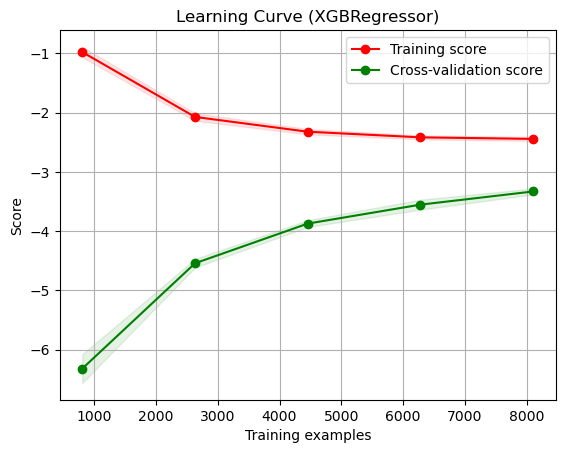

['KAN_L' 'KPC_L' 'MIT' 'NUK_L' 'NUK_U' 'QAS_L' 'QAS_U' 'SCO_L' 'SCO_U'
 'TAS_L' 'THU_L' 'UPE_L' 'UPE_U']
------------------------------------------------------------------------------------
station_names KAN_L
Number of observations at station 392
R^2 score on test set:  0.877445009948909
MSE on test set:  13.774609419288735
MAE on test set 11.62072725202508


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 5                   255               255               274  |   
     6                   256               255               274  |   
     7                   257               256               274  |   
     8                   255               256               274  |   
     9                   261               256               274  |   
2021 5                   252               252               257  |   
     6                   257               254               257  |   
     7                   259               256               257  |   
     8                   259               257               257  |   
     9                   257               257               257  |   
2022 5                   256               256               273  |   
     6                   255               255               273  |   
     7                   259               257               273  |   
     8                   257               257               273  |   
     9                   264               259               273  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 5                        -19                    -19  
     6                        -18                    -19  
     7                        -17                    -18  
     8                        -19                    -18  
     9                        -13                    -18  
2021 5                         -5                     -5  
     6                         -0                     -3  
     7                          2                     -1  
     8                          2                     -0  
     9                         -0                     -0  
2022 5                        -17                    -17  
     6                        -18                    -18  
     7                        -14                    -16  
     8                        -16                    -16  
     9                         -9                    -14

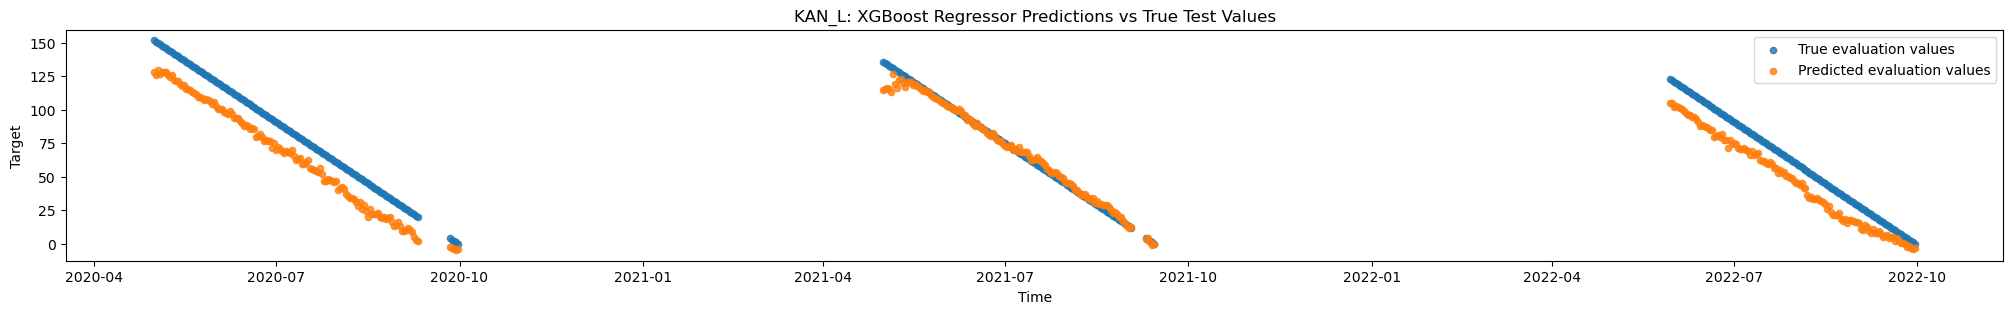

------------------------------------------------------------------------------------
station_names KPC_L
Number of observations at station 281
R^2 score on test set:  0.7704009902559638
MSE on test set:  15.250296604043985
MAE on test set 11.697379084801122


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 6                   252               252               274  |   
     7                   249               250               274  |   
     8                   249               250               274  |   
     9                   258               251               274  |   
2021 6                   251               251               251  |   
     7                   245               248               251  |   
     8                   251               249               251  |   
     9                   249               249               251  |   
2022 6                   251               251               244  |   
     7                   250               250               244  |   
     8                   249               250               244  |   
     9                   246               250               244  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 6                        -22                    -22  
     7                        -25                    -24  
     8                        -25                    -24  
     9                        -16                    -23  
2021 6                         -0                     -0  
     7                         -6                     -3  
     8                         -0                     -2  
     9                         -2                     -2  
2022 6                          7                      7  
     7                          6                      6  
     8                          5                      6  
     9                          2                      6

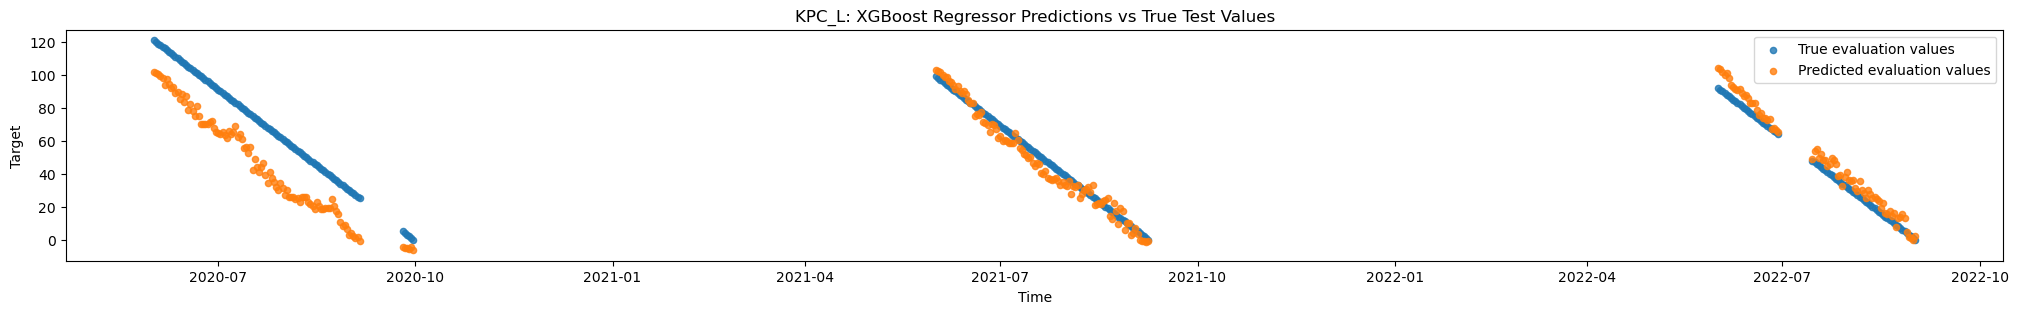

------------------------------------------------------------------------------------
station_names MIT
Number of observations at station 291
R^2 score on test set:  0.9775661365087192
MSE on test set:  5.833109971604252
MAE on test set 4.92995355122073


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 5                   262               262               265  |   
     6                   264               263               265  |   
     7                   262               263               265  |   
     8                   265               263               265  |   
     9                   265               264               265  |   
2021 5                   262               262               273  |   
     6                   264               264               273  |   
     7                   266               265               273  |   
     8                   266               265               273  |   
     9                   268               266               273  |   
2022 7                   268               268               273  |   
     8                   266               266               273  |   
     9                   270               268               273  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 5                         -3                     -3  
     6                         -1                     -2  
     7                         -3                     -2  
     8                         -0                     -2  
     9                         -0                     -1  
2021 5                        -11                    -11  
     6                         -9                     -9  
     7                         -7                     -8  
     8                         -7                     -8  
     9                         -5                     -7  
2022 7                         -5                     -5  
     8                         -7                     -7  
     9                         -3                     -5

------------------------------------------------------------------------------------
station_names NUK_L
Number of observations at station 403
R^2 score on test set:  0.9900294759930739
MSE on test set:  4.217841861362638
MAE on test set 3.3576099905127625


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 5                   269               269               274  |   
     6                   270               270               274  |   
     7                   268               269               274  |   
     8                   270               269               274  |   
     9                   272               270               274  |   
2021 5                   268               268               269  |   
     6                   269               269               269  |   
     7                   269               269               269  |   
     8                   271               269               269  |   
     9                   270               270               269  |   
2022 5                   267               267               273  |   
     6                   267               267               273  |   
     7                   270               268               273  |   
     8                   269               268               273  |   
     9                   274               270               273  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 5                         -5                     -5  
     6                         -4                     -4  
     7                         -6                     -5  
     8                         -4                     -5  
     9                         -2                     -4  
2021 5                         -1                     -1  
     6                          0                     -0  
     7                         -0                     -0  
     8                          2                      0  
     9                          1                      1  
2022 5                         -6                     -6  
     6                         -6                     -6  
     7                         -3                     -5  
     8                         -4                     -5  
     9                          1                     -3

------------------------------------------------------------------------------------
station_names NUK_U
Number of observations at station 240
R^2 score on test set:  0.7600364981595185
MSE on test set:  11.901342456338545
MAE on test set 9.122935013224682


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 6                   257               257               265  |   
     7                   265               264               265  |   
     8                   252               258               265  |   
     9                   262               259               265  |   
2021 7                   265               265               260  |   
     8                   262               263               260  |   
     9                   263               263               260  |   
2022 7                   254               254               273  |   
     8                   253               253               273  |   
     9                   268               258               273  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 6                         -8                     -8  
     7                         -0                     -1  
     8                        -13                     -7  
     9                         -3                     -6  
2021 7                          5                      5  
     8                          2                      3  
     9                          3                      3  
2022 7                        -19                    -19  
     8                        -20                    -20  
     9                         -5                    -15

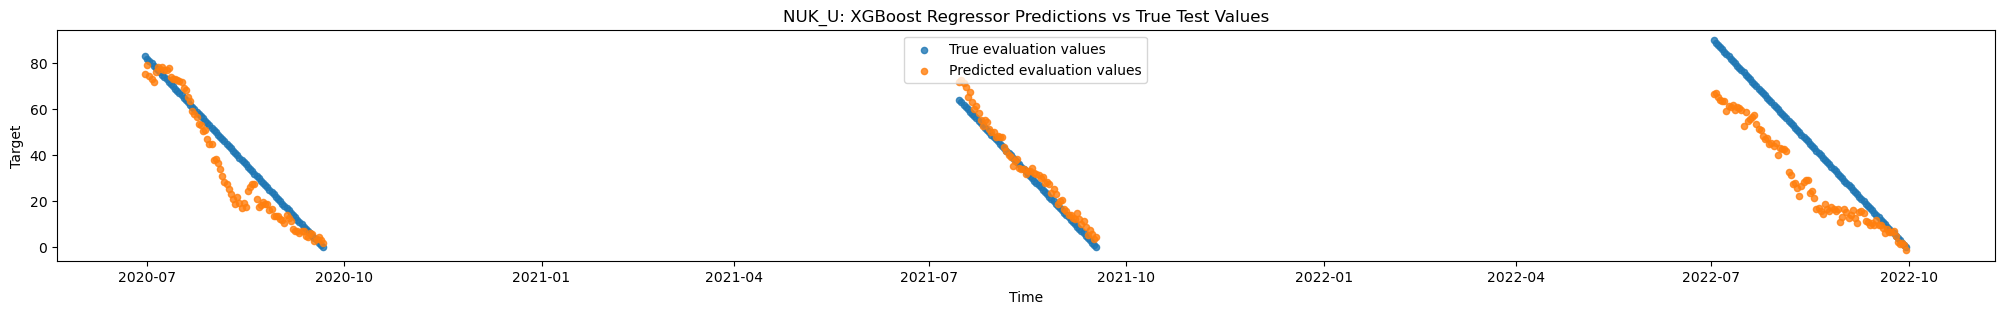

------------------------------------------------------------------------------------
station_names QAS_L
Number of observations at station 362
R^2 score on test set:  0.9969072190017423
MSE on test set:  2.1144478691266633
MAE on test set 1.587165309702823


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 5                   272               272               274  |   
     6                   274               273               274  |   
     7                   274               273               274  |   
     8                   273               273               274  |   
     9                   273               273               274  |   
2021 6                   272               272               273  |   
     7                   273               273               273  |   
     8                   273               273               273  |   
     9                   274               273               273  |   
2022 5                   271               271               273  |   
     6                   271               271               273  |   
     7                   273               272               273  |   
     8                   274               272               273  |   
     9                   274               273               273  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 5                         -2                     -2  
     6                         -0                     -1  
     7                         -0                     -1  
     8                         -1                     -1  
     9                         -1                     -1  
2021 6                         -1                     -1  
     7                          0                     -0  
     8                         -0                     -0  
     9                          1                     -0  
2022 5                         -2                     -2  
     6                         -2                     -2  
     7                         -0                     -1  
     8                          1                     -1  
     9                          1                     -0

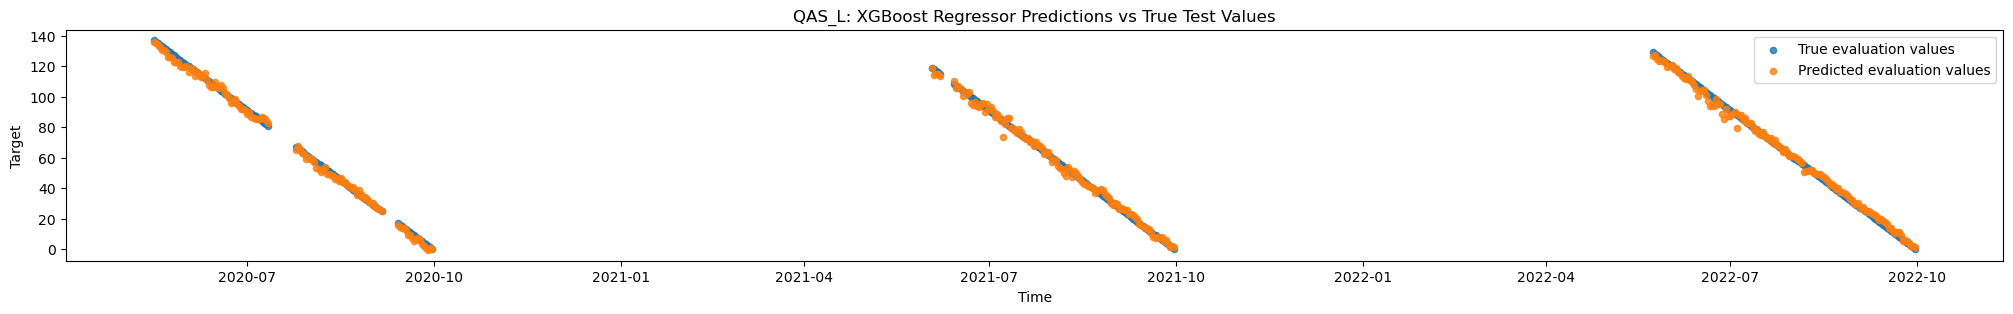

------------------------------------------------------------------------------------
station_names QAS_U
Number of observations at station 99
R^2 score on test set:  0.8256943551408097
MSE on test set:  8.88406513169747
MAE on test set 6.951477399980179


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 8                   263               263               261  |   
     9                   268               265               261  |   
2022 6                   253               253               273  |   
     7                   254               254               273  |   
     8                   261               260               273  |   
     9                   273               266               273  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 8                          2                      2  
     9                          7                      4  
2022 6                        -20                    -20  
     7                        -19                    -19  
     8                        -12                    -13  
     9                         -0                     -7

------------------------------------------------------------------------------------
station_names SCO_L
Number of observations at station 370
R^2 score on test set:  0.9667588947088974
MSE on test set:  6.621022918875263
MAE on test set 5.060216463256527


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 5                   262               262               257  |   
     6                   256               259               257  |   
     7                   260               259               257  |   
     8                   260               259               257  |   
     9                   258               259               257  |   
2021 5                   262               262               261  |   
     6                   258               259               261  |   
     7                   260               260               261  |   
     8                   259               260               261  |   
     9                   262               260               261  |   
2022 5                   262               262               272  |   
     6                   260               260               272  |   
     7                   261               261               272  |   
     8                   260               261               272  |   
     9                   267               262               272  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 5                          5                      5  
     6                         -1                      2  
     7                          3                      2  
     8                          3                      2  
     9                          1                      2  
2021 5                          1                      1  
     6                         -3                     -2  
     7                         -1                     -1  
     8                         -2                     -1  
     9                          1                     -1  
2022 5                        -10                    -10  
     6                        -12                    -12  
     7                        -11                    -11  
     8                        -12                    -11  
     9                         -5                    -10

------------------------------------------------------------------------------------
station_names SCO_U
Number of observations at station 318
R^2 score on test set:  0.8733953244164809
MSE on test set:  12.00796516297632
MAE on test set 8.049726894301063


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 6                   251               251               249  |   
     7                   251               251               249  |   
     8                   252               251               249  |   
     9                   252               251               249  |   
2021 5                   254               254               251  |   
     6                   251               253               251  |   
     7                   250               252               251  |   
     8                   253               252               251  |   
     9                   257               252               251  |   
2022 6                   251               251               273  |   
     7                   250               250               273  |   
     8                   250               250               273  |   
     9                   267               253               273  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 6                          2                      2  
     7                          2                      2  
     8                          3                      2  
     9                          3                      2  
2021 5                          3                      3  
     6                          0                      2  
     7                         -1                      1  
     8                          2                      1  
     9                          6                      1  
2022 6                        -22                    -22  
     7                        -23                    -23  
     8                        -23                    -23  
     9                         -6                    -20

------------------------------------------------------------------------------------
station_names TAS_L
Number of observations at station 329
R^2 score on test set:  0.9799117995410687
MSE on test set:  4.843743736769906
MAE on test set 3.838946401178384


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 6                   273               273               274  |   
     7                   273               273               274  |   
     8                   271               272               274  |   
     9                   268               271               274  |   
2021 6                   267               267               273  |   
     7                   268               267               273  |   
     8                   271               269               273  |   
     9                   271               269               273  |   
2022 5                   269               269               273  |   
     6                   267               268               273  |   
     7                   268               268               273  |   
     8                   266               267               273  |   
     9                   274               269               273  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 6                         -1                     -1  
     7                         -1                     -1  
     8                         -3                     -2  
     9                         -6                     -3  
2021 6                         -6                     -6  
     7                         -5                     -6  
     8                         -2                     -4  
     9                         -2                     -4  
2022 5                         -4                     -4  
     6                         -6                     -5  
     7                         -5                     -5  
     8                         -7                     -6  
     9                          1                     -4

------------------------------------------------------------------------------------
station_names THU_L
Number of observations at station 185
R^2 score on test set:  0.8314468676192127
MSE on test set:  8.243117166508386
MAE on test set 7.338639943986325


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 7                   261               261               253  |   
     8                   255               258               253  |   
     9                   256               257               253  |   
2021 8                   259               259               271  |   
     9                   268               262               271  |   
2022 6                   261               261               252  |   
     7                   261               261               252  |   
     8                   260               261               252  |   
     9                   261               261               252  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 7                          8                      8  
     8                          2                      5  
     9                          3                      4  
2021 8                        -12                    -12  
     9                         -3                     -9  
2022 6                          9                      9  
     7                          9                      9  
     8                          8                      9  
     9                          9                      9

------------------------------------------------------------------------------------
station_names UPE_L
Number of observations at station 307
R^2 score on test set:  0.9155197551274868
MSE on test set:  9.13405061514123
MAE on test set 8.000675777367737


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 6                   261               261               274  |   
     7                   260               260               274  |   
     8                   258               260               274  |   
     9                   264               261               274  |   
2021 5                   263               263               256  |   
     6                   261               261               256  |   
     7                   260               261               256  |   
     8                   261               261               256  |   
     9                   259               261               256  |   
2022 6                   261               261               268  |   
     7                   259               260               268  |   
     8                   260               260               268  |   
     9                   267               262               268  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 6                        -13                    -13  
     7                        -14                    -14  
     8                        -16                    -14  
     9                        -10                    -13  
2021 5                          7                      7  
     6                          5                      5  
     7                          4                      5  
     8                          5                      5  
     9                          3                      5  
2022 6                         -7                     -7  
     7                         -9                     -8  
     8                         -8                     -8  
     9                         -1                     -6

------------------------------------------------------------------------------------
station_names UPE_U
Number of observations at station 202
R^2 score on test set:  0.8829570626649953
MSE on test set:  9.632461482163128
MAE on test set 8.254186365513666


Monthly Pred Mean Running Pred Mean Actual Event Date     \
year month                                                            
2020 7                   262               262               253  |   
     8                   252               256               253  |   
     9                   258               257               253  |   
2021 6                   263               263               273  |   
     7                   259               261               273  |   
     8                   260               260               273  |   
     9                   271               262               273  |   
2022 7                   261               261               264  |   
     8                   256               259               264  |   
     9                   269               261               264  |   

           Monthly Pred Mean Diff Running Pred Mean Diff  
year month                                                
2020 7                          9                      9  
     8                         -1                      3  
     9                          5                      4  
2021 6                        -10                    -10  
     7                        -14                    -12  
     8                        -13                    -13  
     9                         -2                    -11  
2022 7                         -3                     -3  
     8                         -8                     -5  
     9                          5                     -3

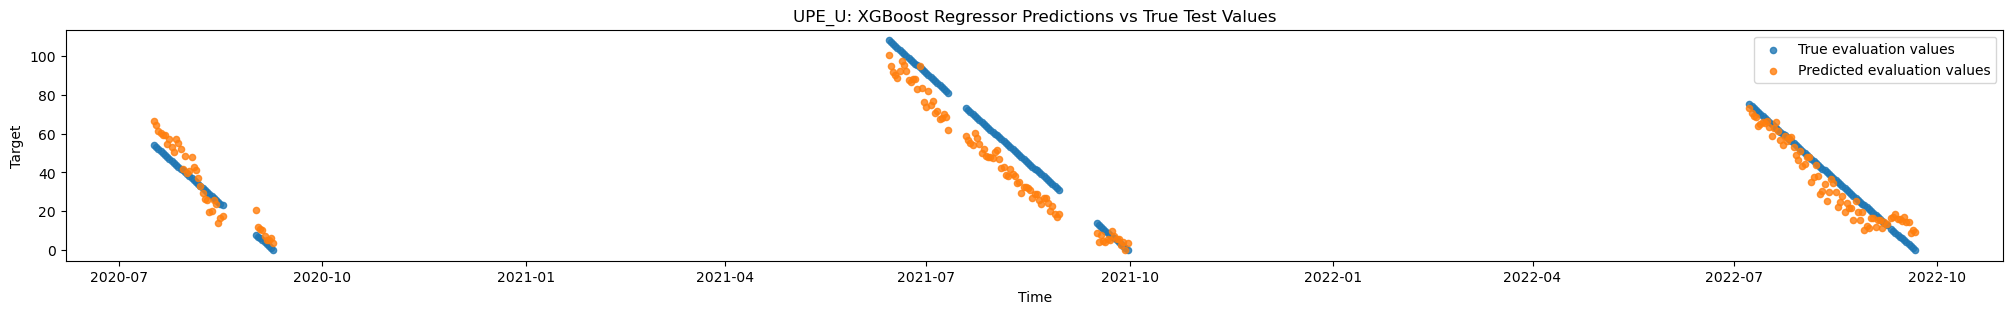

In [41]:


#X_train.reset_index(drop=True,inplace=True)
#y_train.reset_index(drop=True,inplace=True)
# XGB Regressor
model = xgb.XGBRegressor()

param_grid ={
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15],
    'min_child_weight': [3, 5,  10], 
    'gamma': [0, 0.1, 0.5, 1], 
    'subsample': [0.5, 0.7, 1], 
    'colsample_bytree': [0.5, 0.7, 1]
}

param_grid ={
    'learning_rate': [0.01, 0.1],
    'max_depth': [5,  15],
    'min_child_weight': [3,  10], 
    'gamma': [0, 0.1,  1], 
    'subsample': [0.5, 1], 
    'colsample_bytree': [0.5, 1]
}


# Define the hyperparameter grid for tuning
param_grid ={
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_child_weight': [1, 2, 4, 6, 8, 10], 
    'gamma': [0, 0.1, 0.5, 0.7, 1], 
    'subsample': [0.5, 0.7, 0.8, 0.9, 1], 
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}



# paramgrid start
#param_grid = {
# 'colsample_bytree': [0.9], 'gamma': [0], 'learning_rate': [0.05], 'max_depth': [15], 'min_child_weight': [10], 'subsample': [0.8]
# }
#param_grid = {'colsample_bytree': [1], 'gamma': [0], 'learning_rate': [0.1], 'max_depth': [5], 'min_child_weight': [3], 'subsample': [1]}
# paramgrid end

#{'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 1}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=custom_time_series_cv(X_train), n_jobs=-1, verbose=5, scoring='neg_mean_absolute_error')

# custom_time_series_cv(X_train)
# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

# Print the best hyperparameters and the corresponding R^2 score on the test set

print(f"Best hyperparameters: ", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
# Save the best model parameters as 'model' variable
xgb_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred) 
std_seasonality = 

print("Average MAE test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of MAE test scores from cv:", grid_search.cv_results_["std_test_score"][0])

mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_

print('------------------------------------------------------------------------------------')
print(f'MAE on validation set: ', mae)
print(f"R^2 score on validation set: ", r2)
#print(f"MSE on validation set: ", mse)


#plot_learning_curve(best_estimator, "Learning Curve (XGBRegressor)", X_train, y_train, cv=cv)


#station_performance_viz(df, X_train, X_test, y_train, y_test, 'XGBoost Regressor', xgb_model)

In [37]:
print(grid_search.best_params_)

{'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 1}


## Linnear Regression

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best hyperparameters:  {'fit_intercept': False}
------------------------------------------------------------------------------------
Average R^2 test score from cv : -17.874911449681186
Standard deviation of R^2 test scores from cv: 0.24004778492894988
------------------------------------------------------------------------------------
R^2 score on validation set:  0.5350031319306194
MSE on validation set:  24.06341568902359
MAE on validation set:  17.986909223693296


['KAN_L' 'KPC_L' 'MIT' 'NUK_L' 'NUK_U' 'QAS_L' 'QAS_U' 'SCO_L' 'SCO_U'
 'TAS_L' 'THU_L' 'UPE_L' 'UPE_U']
------------------------------------------------------------------------------------
station_names KAN_L
Number of observations at station 543
R^2 score on test set:  0.5755522862846327
MSE on test set:  25.4304774796076
MAE on test set 19.47637990100347


------------------------------------------------------------------------------------
station_names KPC_L
Number of observations at station 254
R^2 score on test set:  0.06254894563270275
MSE on test set:  25.771071446716206
MAE on test set 22.510302928214692


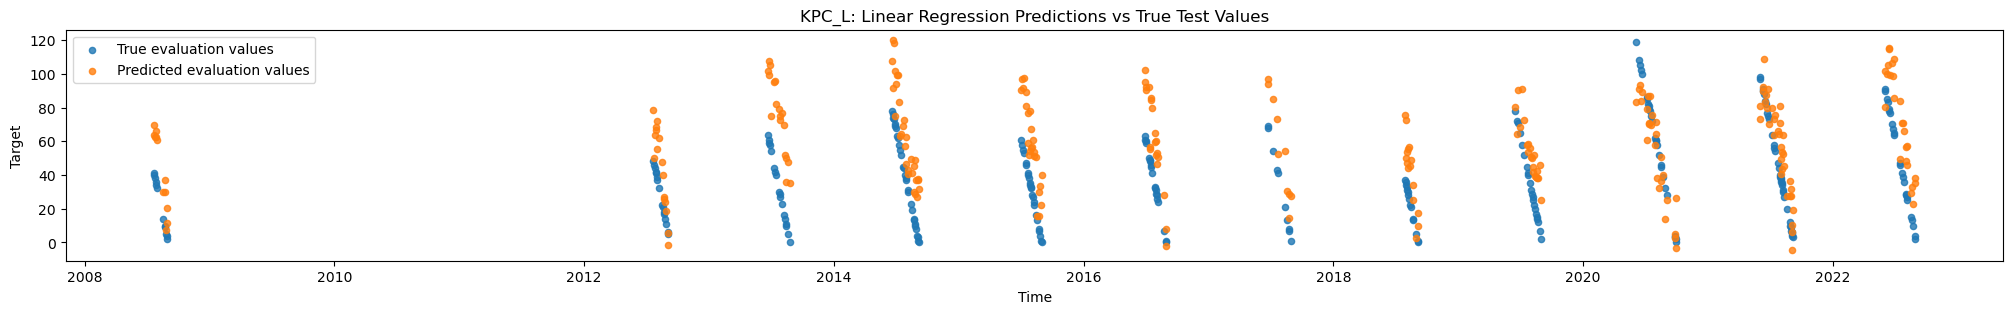

------------------------------------------------------------------------------------
station_names MIT
Number of observations at station 186
R^2 score on test set:  -0.27509792593206295
MSE on test set:  32.65162409669109
MAE on test set 22.786831197629727


------------------------------------------------------------------------------------
station_names NUK_L
Number of observations at station 462
R^2 score on test set:  0.4396468037605772
MSE on test set:  30.988233707362397
MAE on test set 22.820235150371666


------------------------------------------------------------------------------------
station_names NUK_U
Number of observations at station 235
R^2 score on test set:  0.34763031574481906
MSE on test set:  26.118728108014906
MAE on test set 20.451270316286166


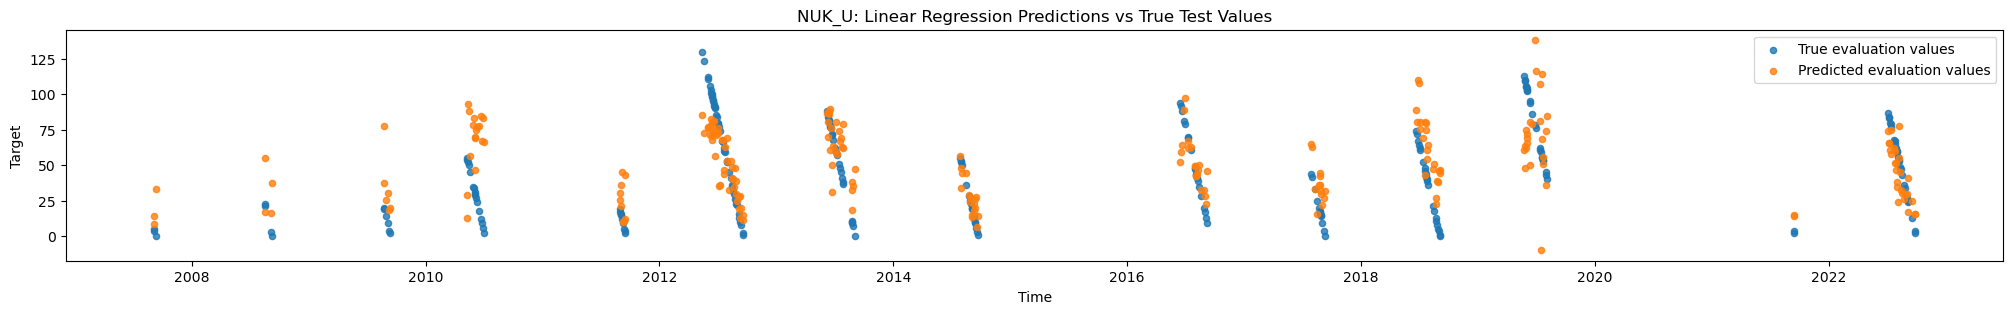

------------------------------------------------------------------------------------
station_names QAS_L
Number of observations at station 366
R^2 score on test set:  0.5332909907533774
MSE on test set:  25.669734008483843
MAE on test set 19.55918607061188


------------------------------------------------------------------------------------
station_names QAS_U
Number of observations at station 153
R^2 score on test set:  -0.04510685197790165
MSE on test set:  18.248033150285142
MAE on test set 14.12943997710418


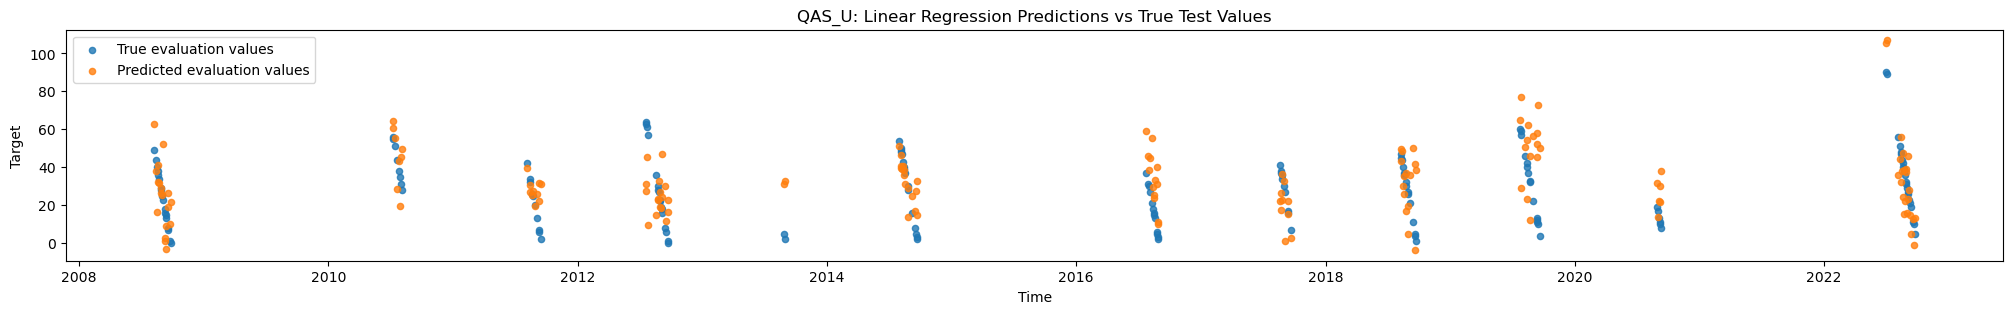

------------------------------------------------------------------------------------
station_names SCO_L
Number of observations at station 397
R^2 score on test set:  0.6955663772070806
MSE on test set:  18.61435333340296
MAE on test set 13.360957067570707


------------------------------------------------------------------------------------
station_names SCO_U
Number of observations at station 366
R^2 score on test set:  0.6814681656695882
MSE on test set:  16.614498701744786
MAE on test set 12.088457137057578


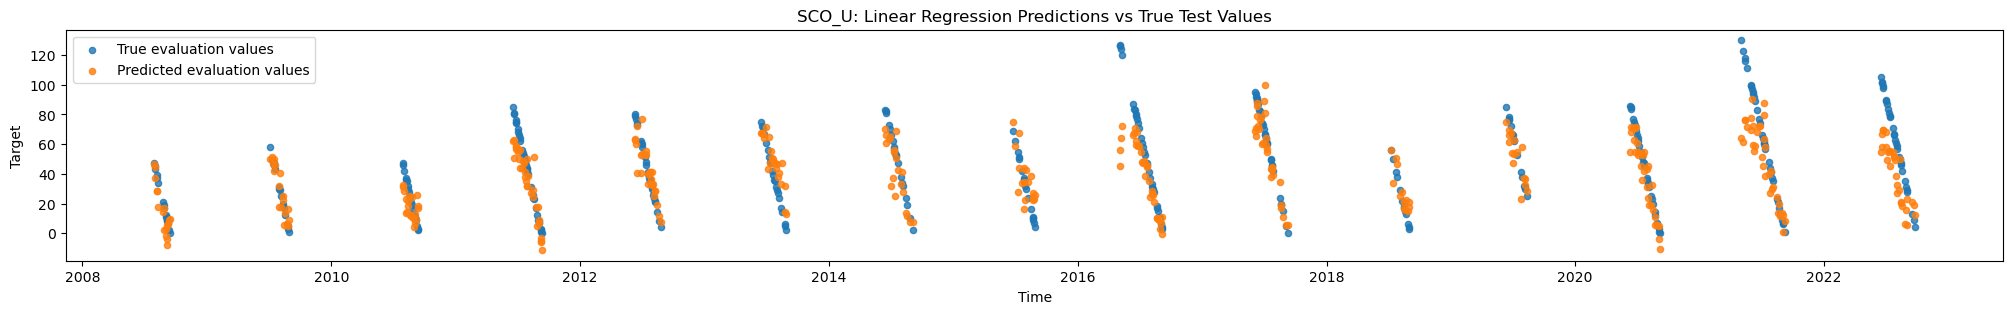

------------------------------------------------------------------------------------
station_names TAS_L
Number of observations at station 157
R^2 score on test set:  0.5847562756056826
MSE on test set:  21.269219795835706
MAE on test set 16.4005972804541


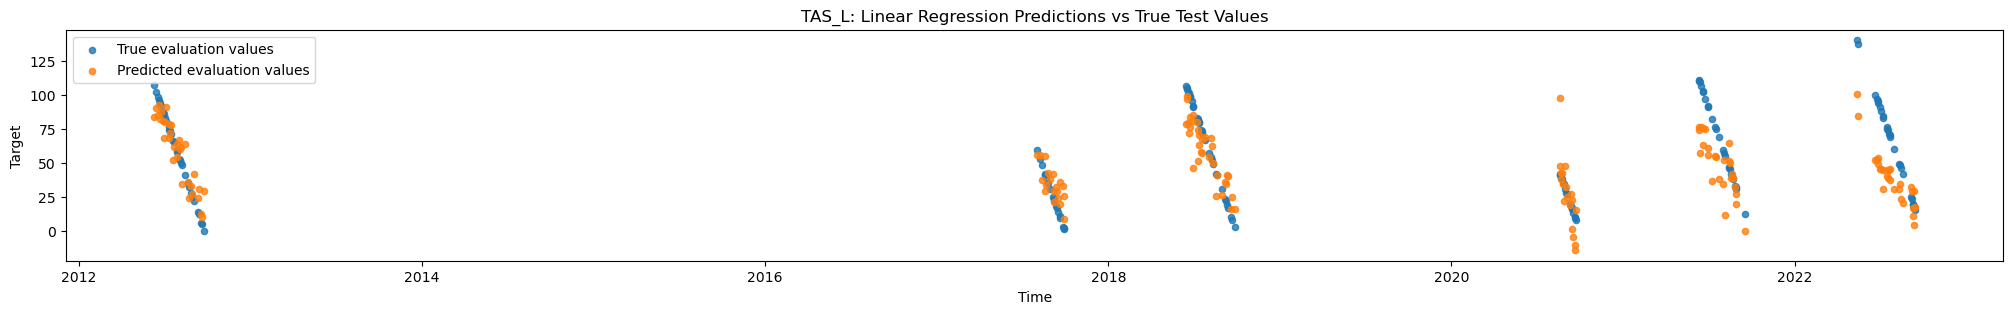

------------------------------------------------------------------------------------
station_names THU_L
Number of observations at station 171
R^2 score on test set:  0.6405279026883439
MSE on test set:  14.143750390064069
MAE on test set 11.069637189757056


------------------------------------------------------------------------------------
station_names UPE_L
Number of observations at station 321
R^2 score on test set:  0.5545524464471635
MSE on test set:  20.129246977939687
MAE on test set 16.67910783596283


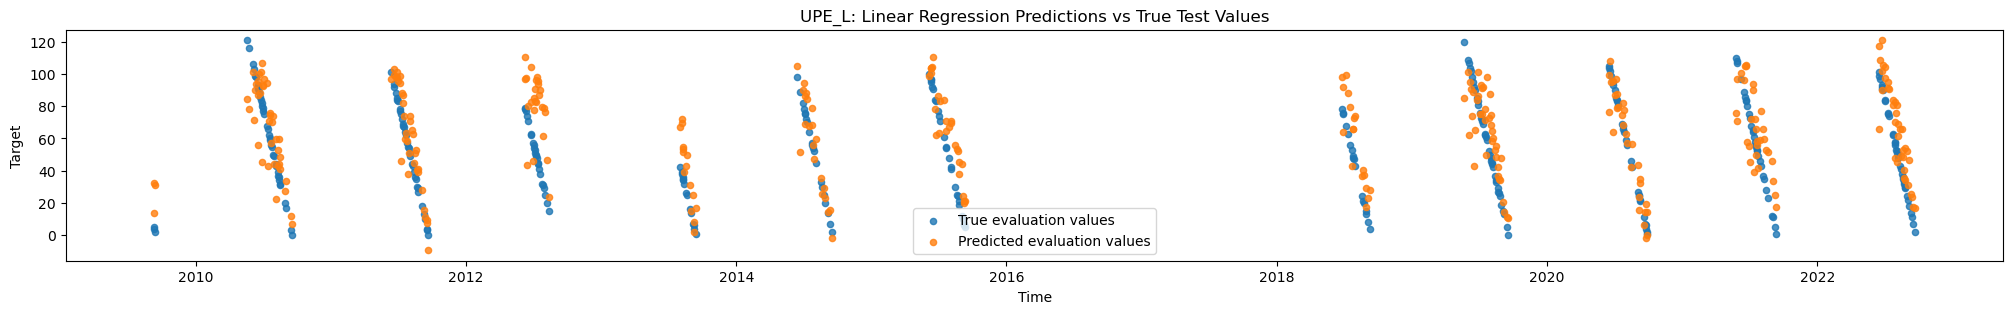

------------------------------------------------------------------------------------
station_names UPE_U
Number of observations at station 170
R^2 score on test set:  0.15772994182707634
MSE on test set:  24.405999905726684
MAE on test set 19.15839849447942


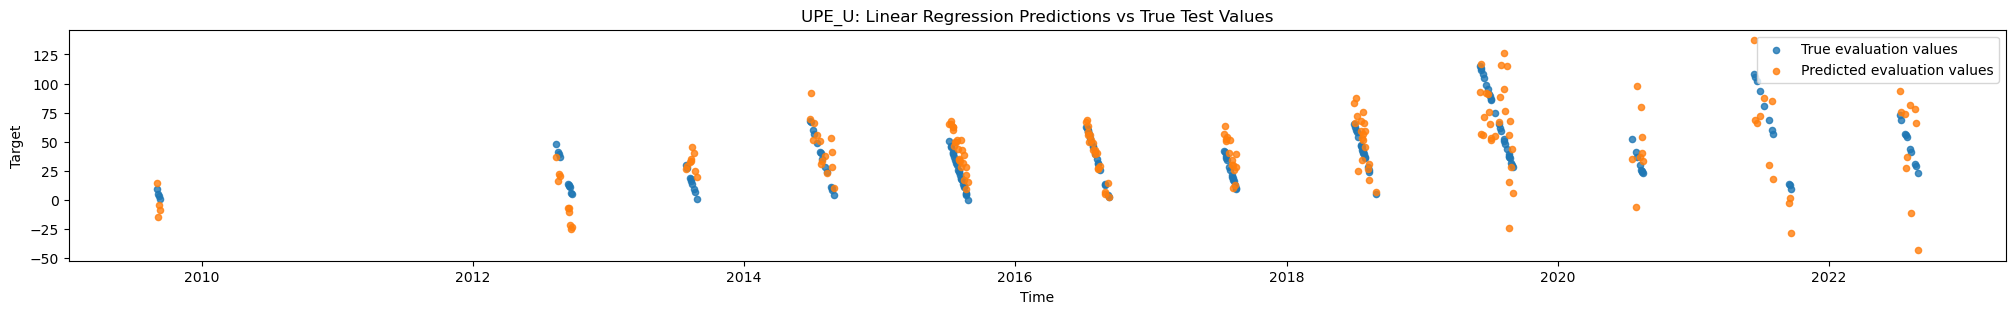

<module 'matplotlib.pyplot' from 'c:\\Users\\mabj16ac\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [37]:
# Linear Regression
model = LinearRegression()

# Define the hyperparameter grid for tuning
param_grid = {
    'fit_intercept': [True, False]
}

# Define the grid search object with 'neg_mean_absolute_error' as the scoring metric
grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding negative mean absolute error score on the test set
print(f"Best hyperparameters: ", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
lr_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = lr_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])

mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set: ", r2)
print(f"MSE on validation set: ", mse)
print(f'MAE on validation set: ', mae)

plot_learning_curve(best_estimator, "Learning Curve (Linear Regression)", X_train, y_train, cv=cv)


station_performance_viz(df, X_train, X_test, y_train, y_test, 'Linear Regression', lr_model)



## KNN

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Average R^2 test score from cv : -18.263436790310372
Standard deviation of R^2 test scores from cv: 0.2352740650135832
------------------------------------------------------------------------------------
R^2 score on validation set:  0.6589620923502839
MSE on validation set:  20.607892828629804
MAE on validation set:  14.533715520864115


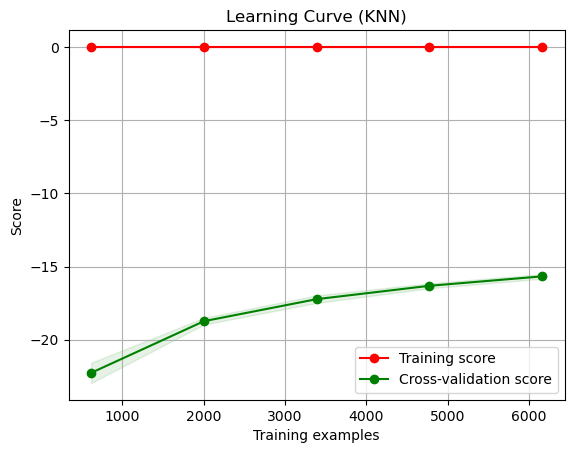

['KAN_L' 'KPC_L' 'MIT' 'NUK_L' 'NUK_U' 'QAS_L' 'QAS_U' 'SCO_L' 'SCO_U'
 'TAS_L' 'THU_L' 'UPE_L' 'UPE_U']
------------------------------------------------------------------------------------
station_names KAN_L
Number of observations at station 543
R^2 score on test set:  0.6353149586005117
MSE on test set:  23.57226908910722
MAE on test set 17.111009789272448


------------------------------------------------------------------------------------
station_names KPC_L
Number of observations at station 254
R^2 score on test set:  0.6625705188495901
MSE on test set:  15.461430980374129
MAE on test set 11.173086380149108


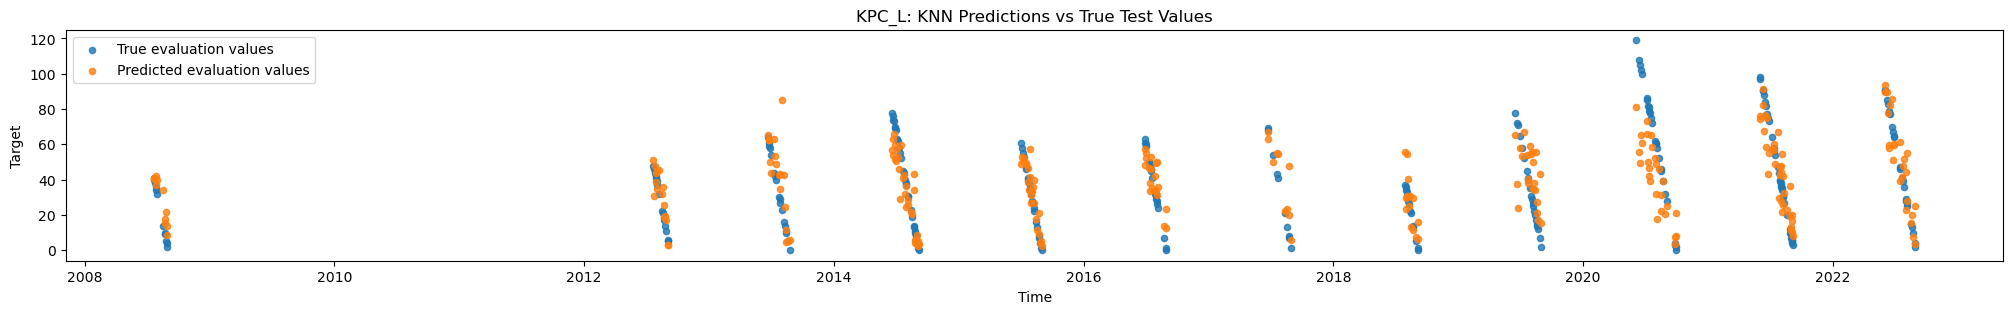

------------------------------------------------------------------------------------
station_names MIT
Number of observations at station 186
R^2 score on test set:  0.5905209053018234
MSE on test set:  18.503287019990836
MAE on test set 13.077676396558502


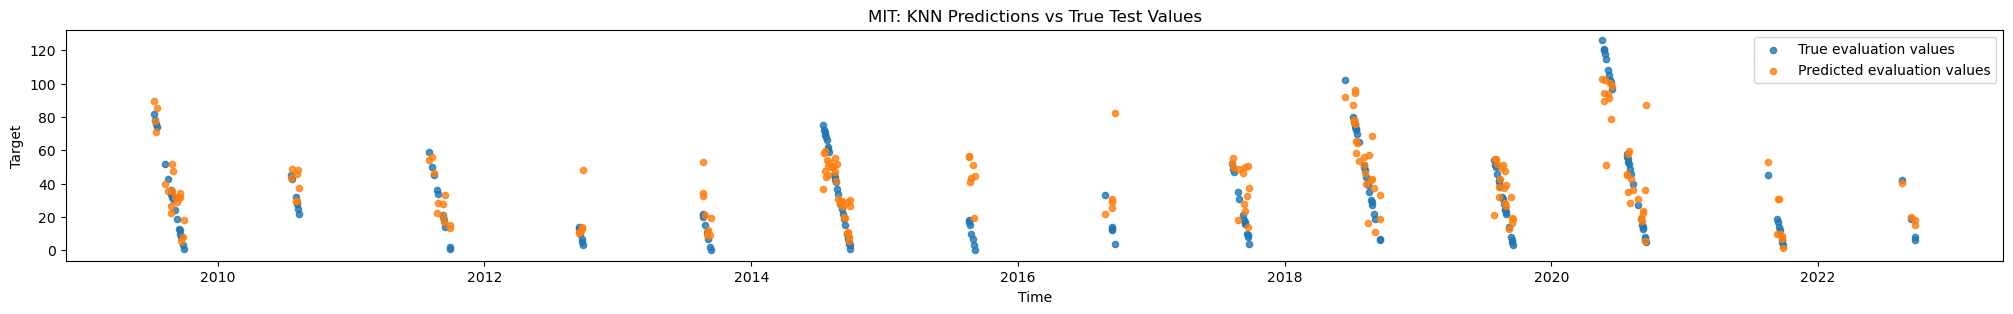

------------------------------------------------------------------------------------
station_names NUK_L
Number of observations at station 462
R^2 score on test set:  0.6132857479129548
MSE on test set:  25.743108369827095
MAE on test set 18.353084439644626


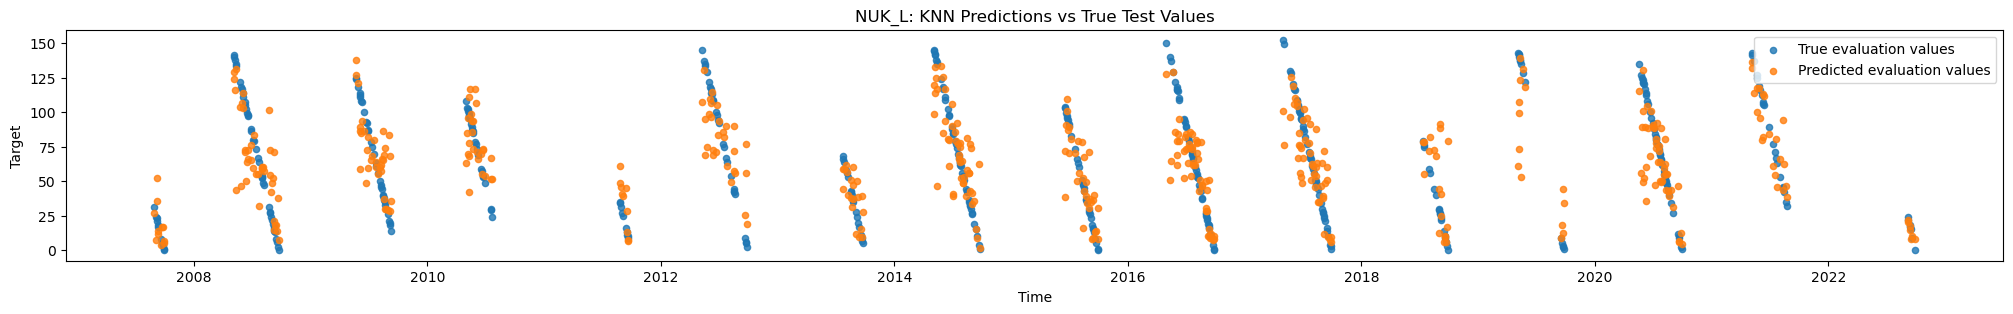

------------------------------------------------------------------------------------
station_names NUK_U
Number of observations at station 235
R^2 score on test set:  0.4446775080601377
MSE on test set:  24.09782081998372
MAE on test set 17.823838835722142


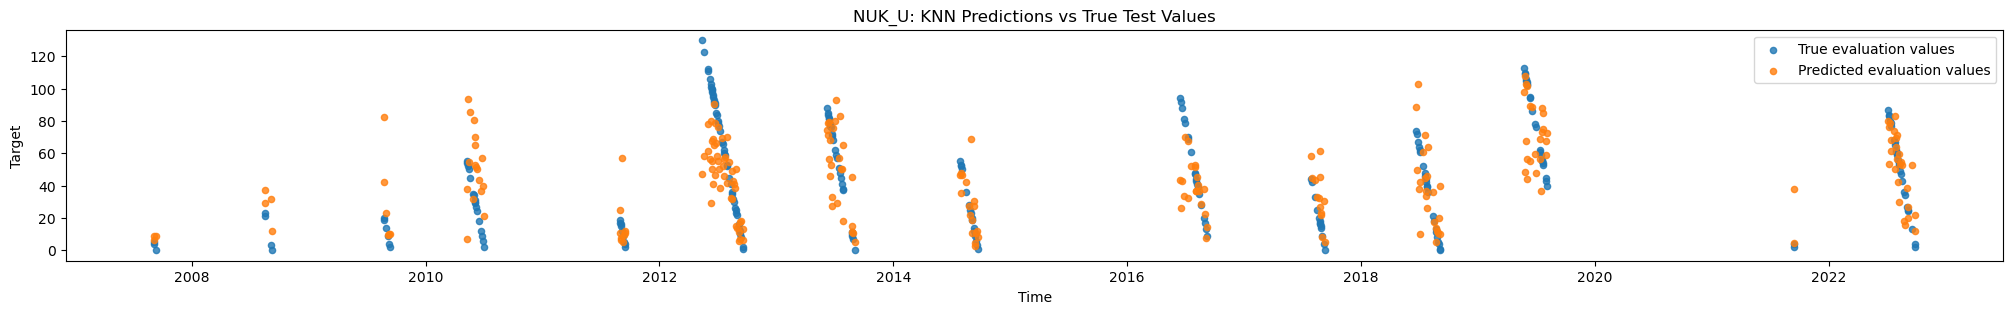

------------------------------------------------------------------------------------
station_names QAS_L
Number of observations at station 366
R^2 score on test set:  0.4975523340857054
MSE on test set:  26.634447531330284
MAE on test set 19.810383609699457


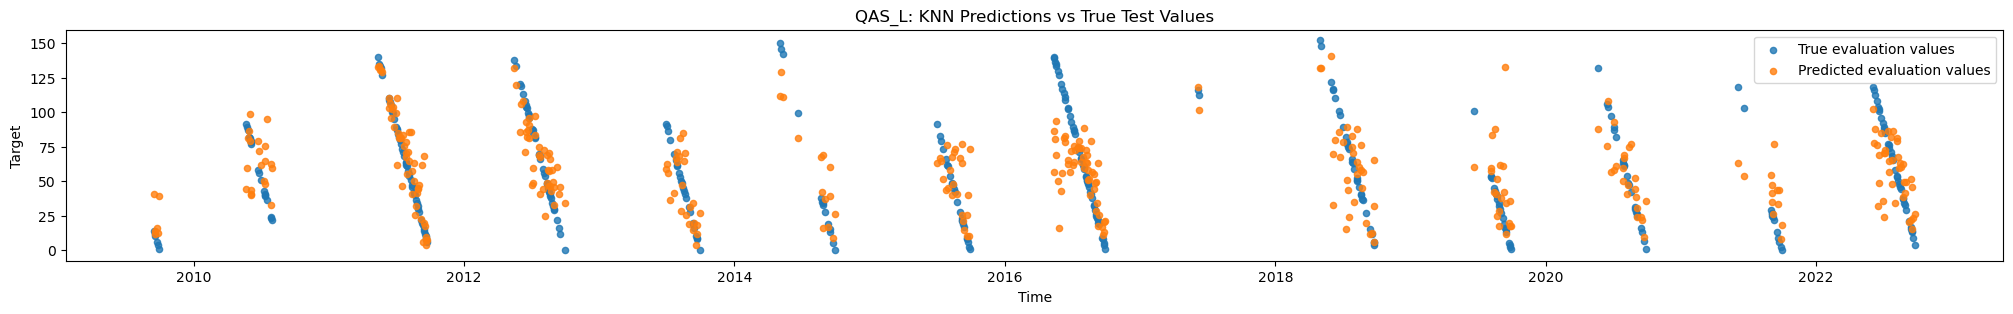

------------------------------------------------------------------------------------
station_names QAS_U
Number of observations at station 153
R^2 score on test set:  0.5696819430357261
MSE on test set:  11.70928829255287
MAE on test set 8.149923428029883


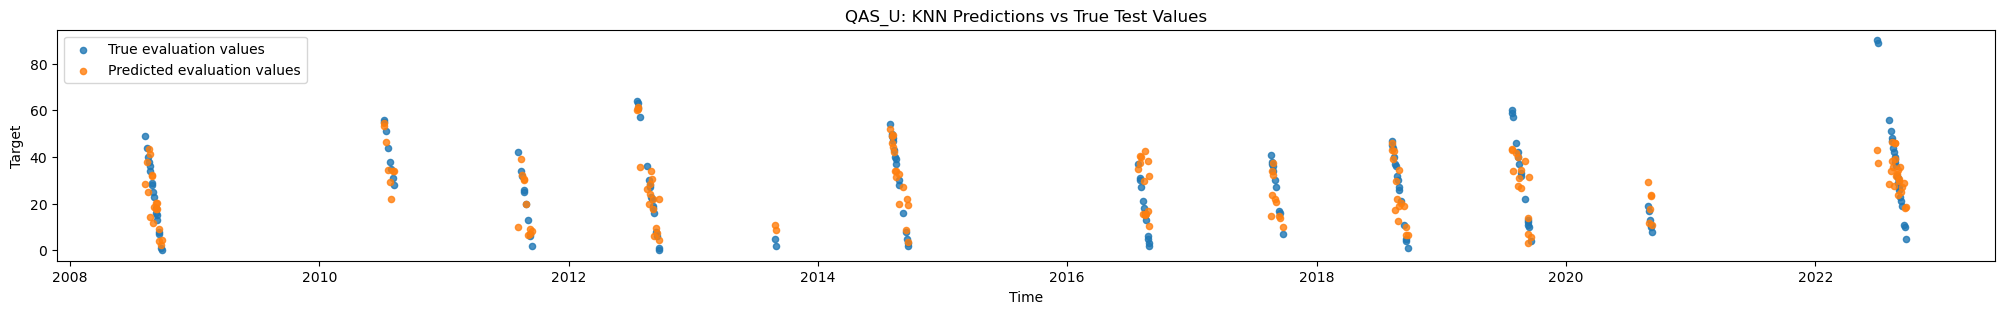

------------------------------------------------------------------------------------
station_names SCO_L
Number of observations at station 397
R^2 score on test set:  0.7156090009743332
MSE on test set:  17.991176693274433
MAE on test set 12.20024471267265


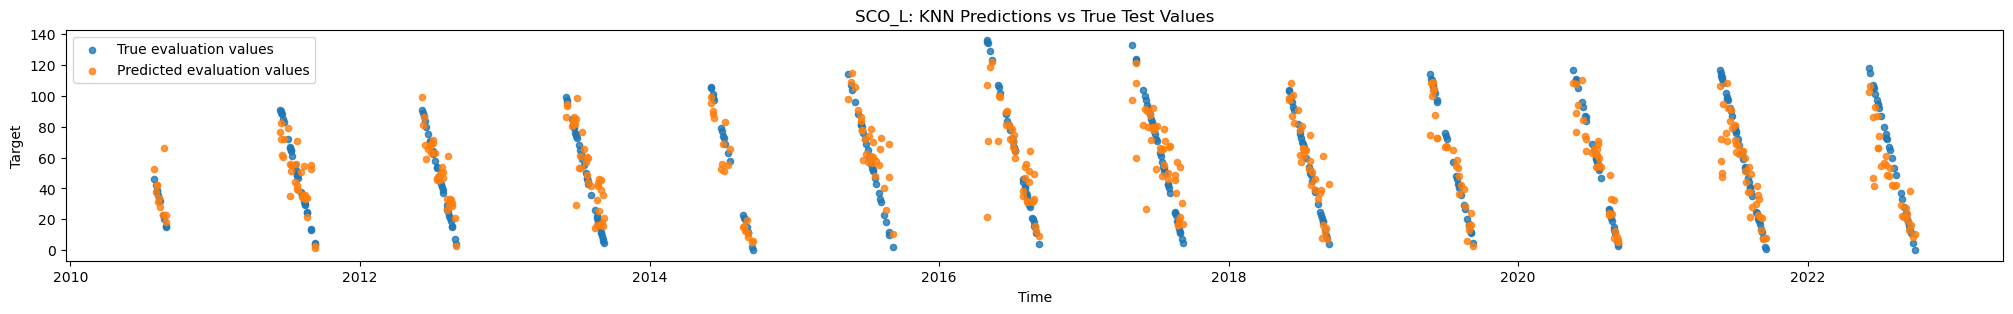

------------------------------------------------------------------------------------
station_names SCO_U
Number of observations at station 366
R^2 score on test set:  0.7266660026819963
MSE on test set:  15.390674282434103
MAE on test set 11.185676745618943


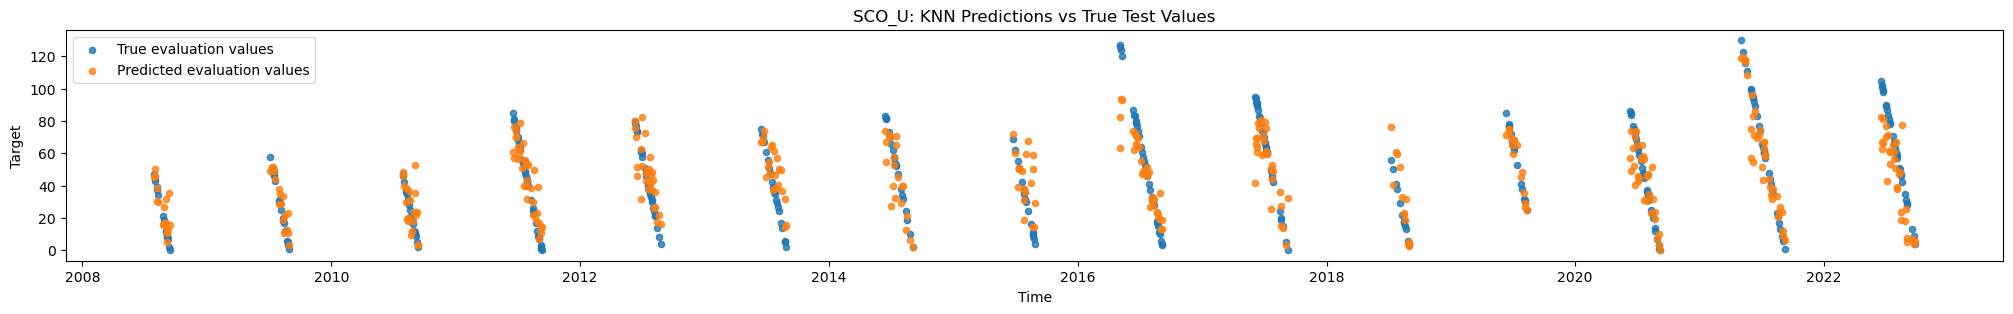

------------------------------------------------------------------------------------
station_names TAS_L
Number of observations at station 157
R^2 score on test set:  0.6034086256902568
MSE on test set:  20.78603492078986
MAE on test set 16.37630826496357


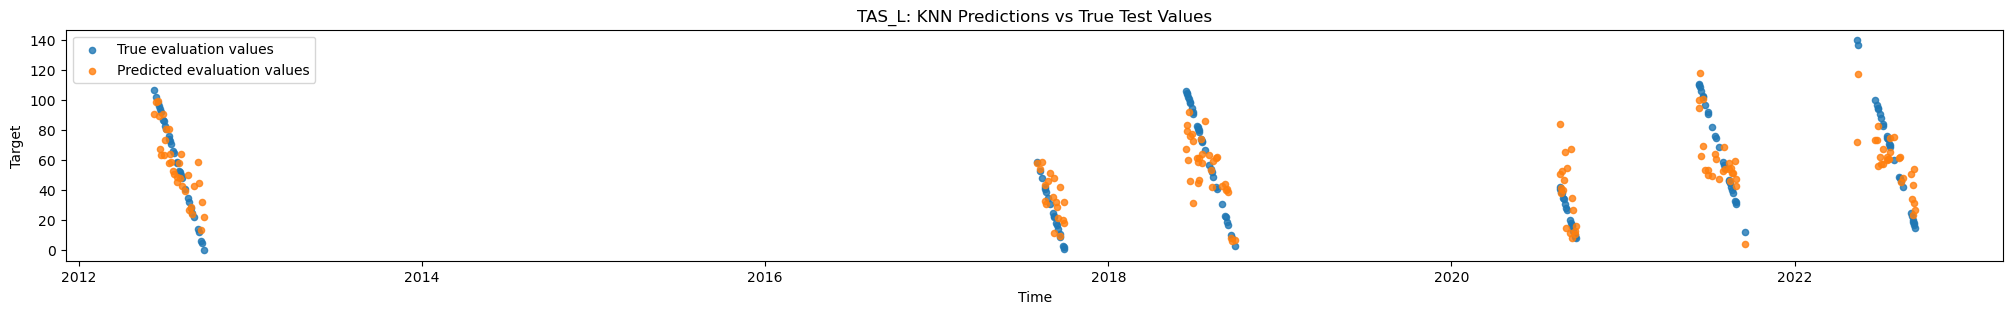

------------------------------------------------------------------------------------
station_names THU_L
Number of observations at station 171
R^2 score on test set:  0.6542013500980344
MSE on test set:  13.872145559418207
MAE on test set 10.163947662588615


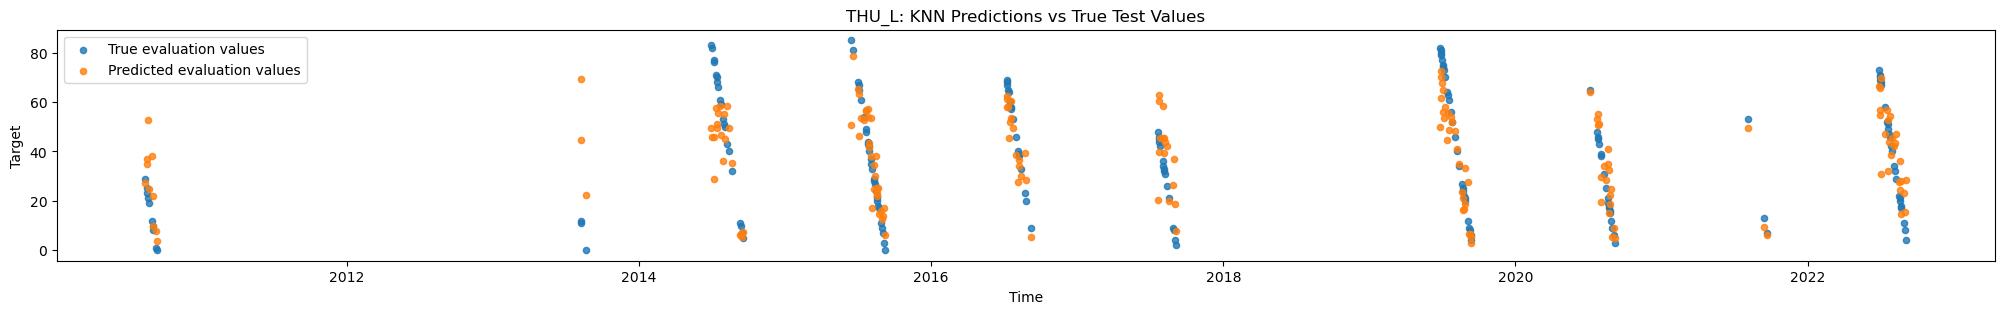

------------------------------------------------------------------------------------
station_names UPE_L
Number of observations at station 321
R^2 score on test set:  0.6742928135826696
MSE on test set:  17.212458650366308
MAE on test set 12.516614604141699


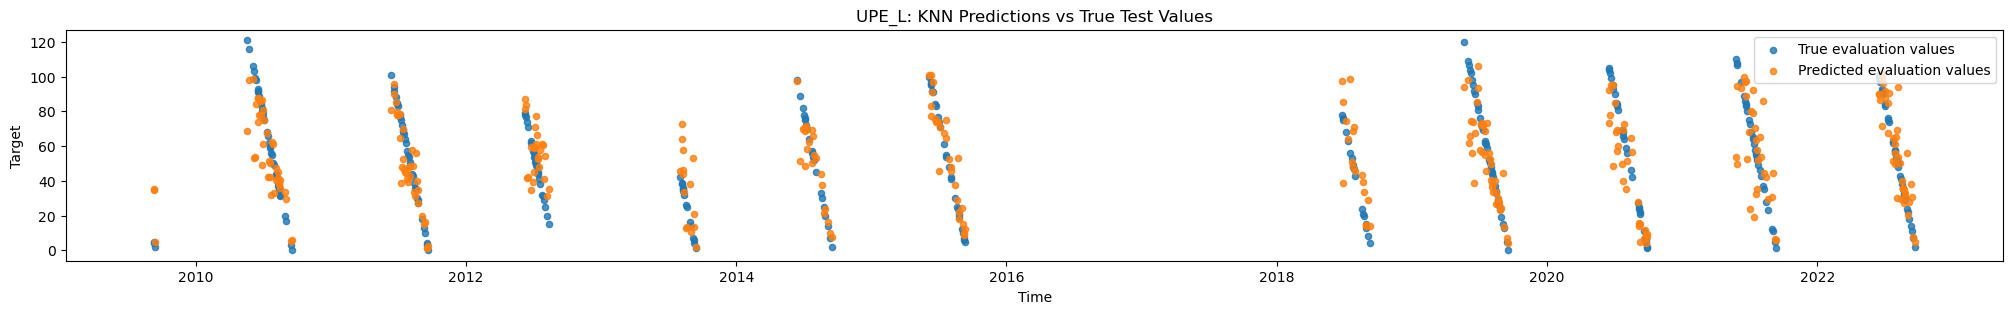

------------------------------------------------------------------------------------
station_names UPE_U
Number of observations at station 170
R^2 score on test set:  0.6230125287148752
MSE on test set:  16.3280522980056
MAE on test set 11.533052468743815


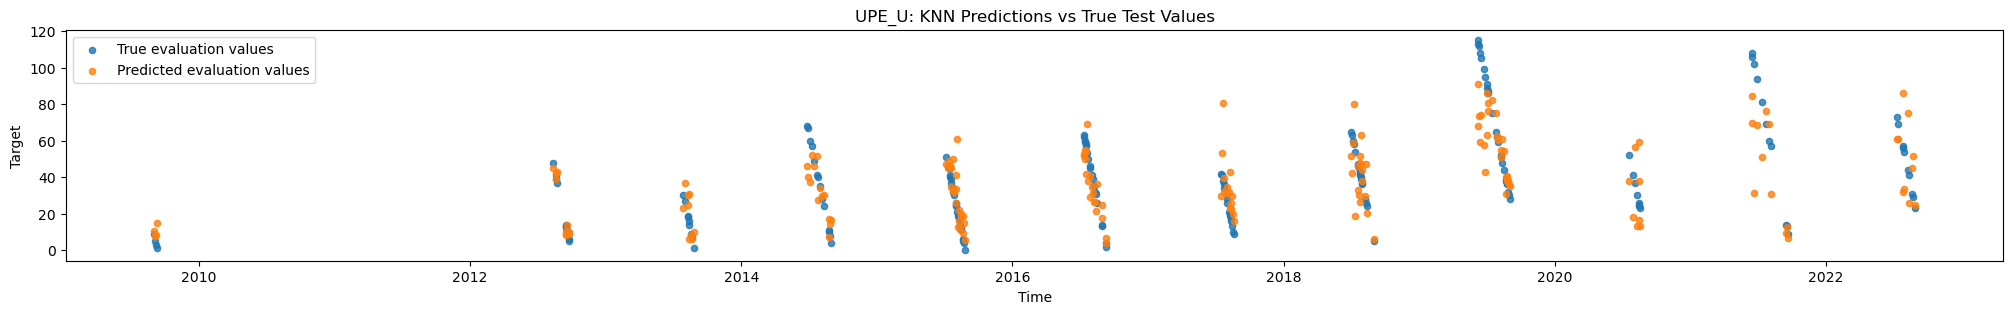

<module 'matplotlib.pyplot' from 'c:\\Users\\mabj16ac\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [25]:
# Create the k-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()

# Define hyperparameter search space
param_grid = {
    'n_neighbors': range(1, 11),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create grid search object
grid_search = GridSearchCV(knn_model, param_grid, cv=cv, n_jobs=-1, verbose = 2, scoring='neg_mean_absolute_error')

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

knn_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = knn_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])

mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set: ", r2)
print(f"MSE on validation set: ", mse)
print(f'MAE on validation set: ', mae)

plot_learning_curve(best_estimator, "Learning Curve (KNN)", X_train, y_train, cv=cv)

station_performance_viz(df, X_train, X_test, y_train, y_test, 'KNN', knn_model)

## HistGB Regressor

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Average R^2 test score from cv : -12.886910316747654
Standard deviation of R^2 test scores from cv: 0.1882267609871958
------------------------------------------------------------------------------------
R^2 score on validation set:  0.7543131228233201
MSE on validation set:  17.704407338487094
MAE on validation set:  12.35829369924612


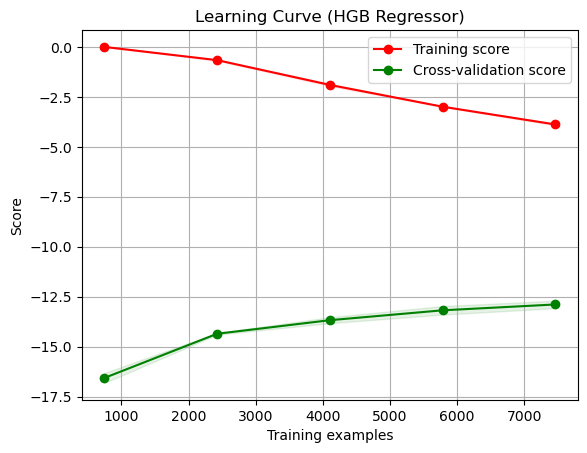

['KAN_L' 'KPC_L' 'MIT' 'NUK_L' 'NUK_U' 'QAS_L' 'QAS_U' 'SCO_L' 'SCO_U'
 'TAS_L' 'THU_L' 'UPE_L' 'UPE_U']
------------------------------------------------------------------------------------
station_names KAN_L
Number of observations at station 544
R^2 score on test set:  0.7454439808655466
MSE on test set:  19.34416764045575
MAE on test set 13.492980608736532


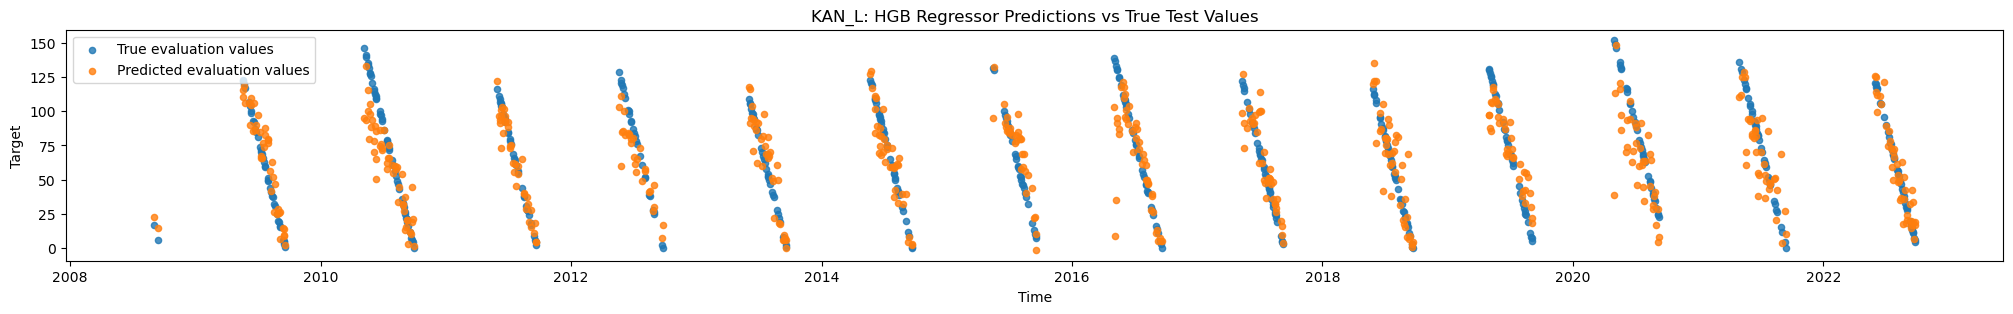

------------------------------------------------------------------------------------
station_names KPC_L
Number of observations at station 254
R^2 score on test set:  0.7885667131044246
MSE on test set:  12.299281297714447
MAE on test set 9.169038226293008


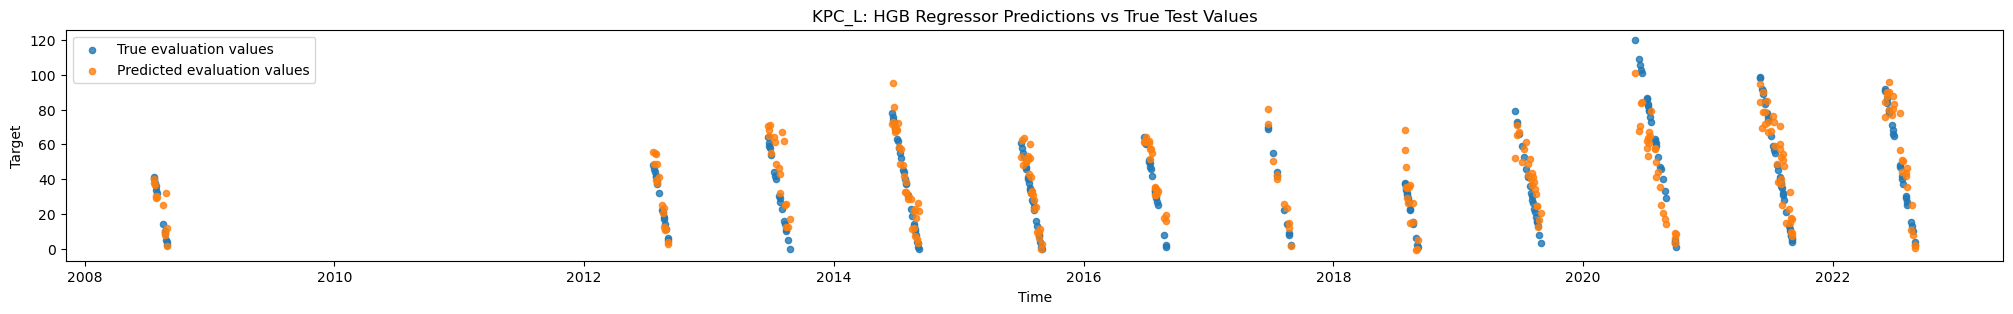

------------------------------------------------------------------------------------
station_names MIT
Number of observations at station 302
R^2 score on test set:  0.7651363458356837
MSE on test set:  17.68435528508717
MAE on test set 12.374670866290986


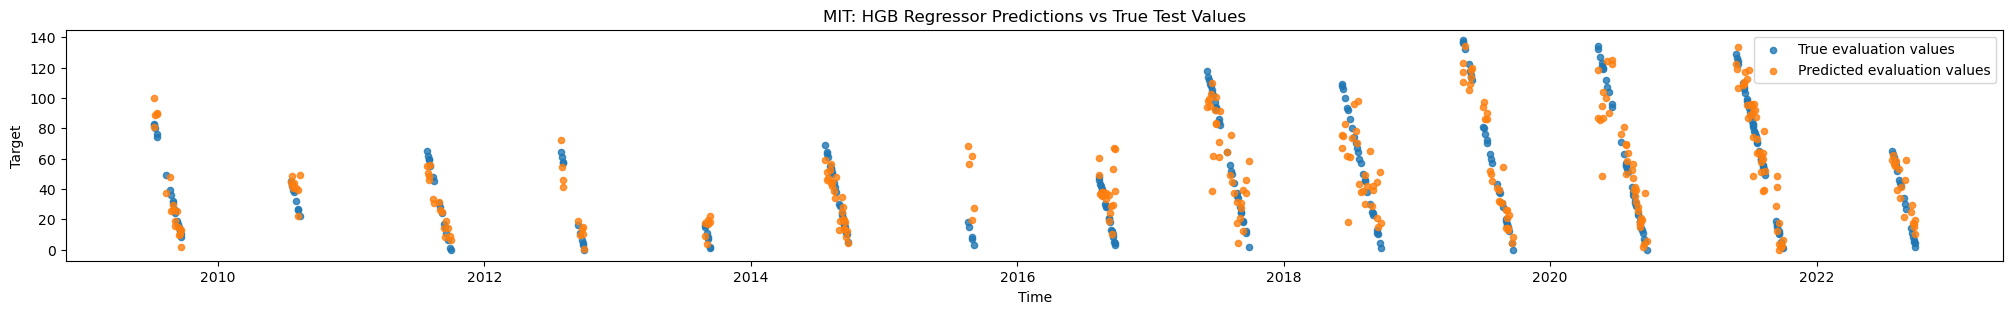

------------------------------------------------------------------------------------
station_names NUK_L
Number of observations at station 589
R^2 score on test set:  0.6884853357286546
MSE on test set:  22.736461999376917
MAE on test set 15.298218774804978


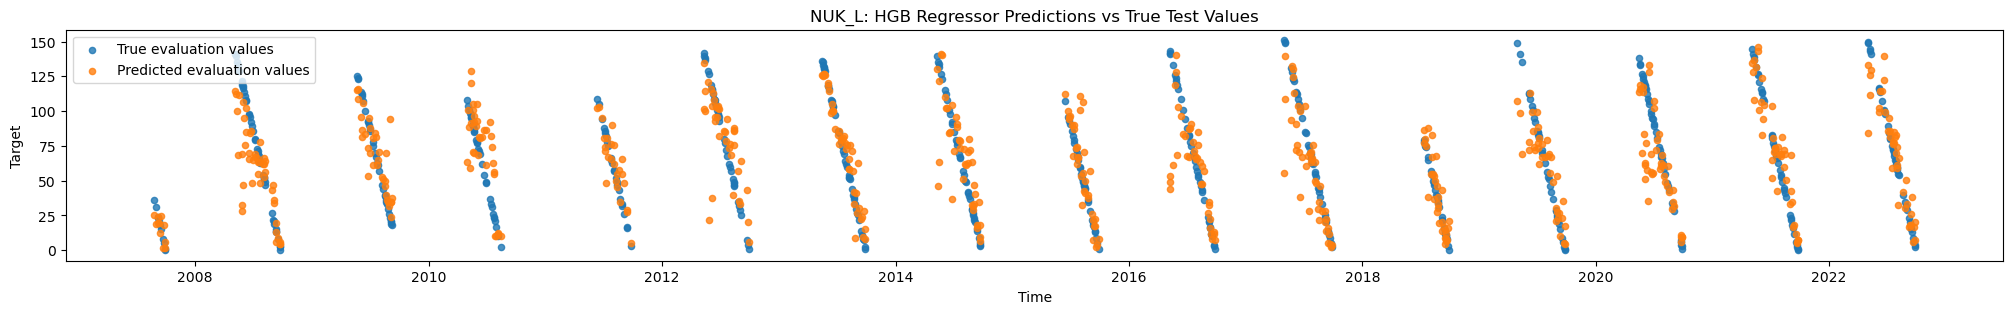

------------------------------------------------------------------------------------
station_names NUK_U
Number of observations at station 314
R^2 score on test set:  0.5659463284695554
MSE on test set:  19.584709915187894
MAE on test set 14.524870864888767


------------------------------------------------------------------------------------
station_names QAS_L
Number of observations at station 532
R^2 score on test set:  0.7208096114260241
MSE on test set:  21.151391357501474
MAE on test set 15.486126739330606


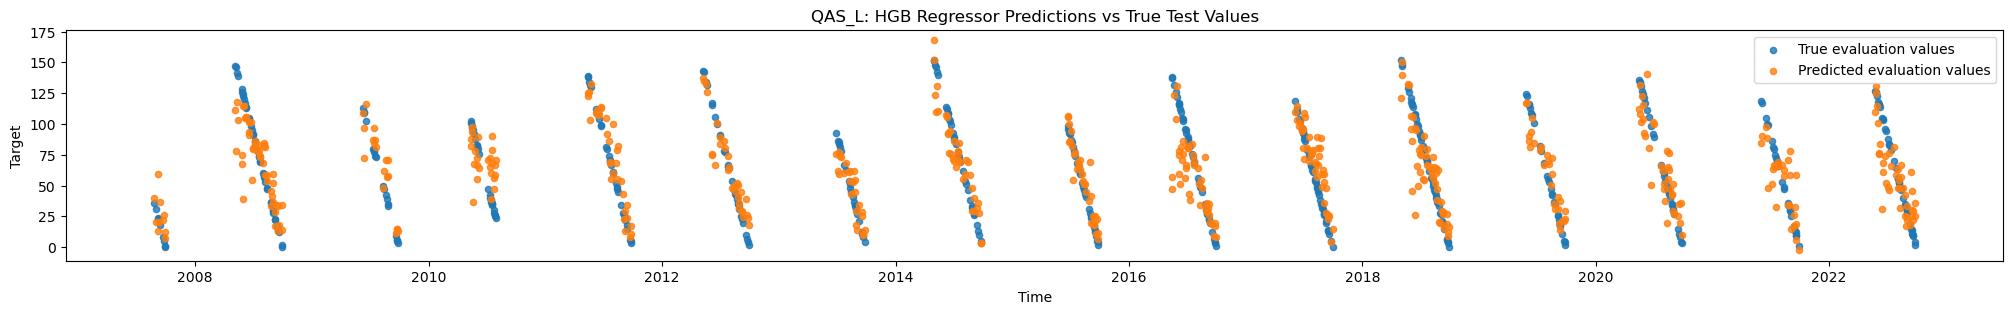

------------------------------------------------------------------------------------
station_names QAS_U
Number of observations at station 173
R^2 score on test set:  0.5375498538126872
MSE on test set:  11.44293697381112
MAE on test set 8.55826925398451


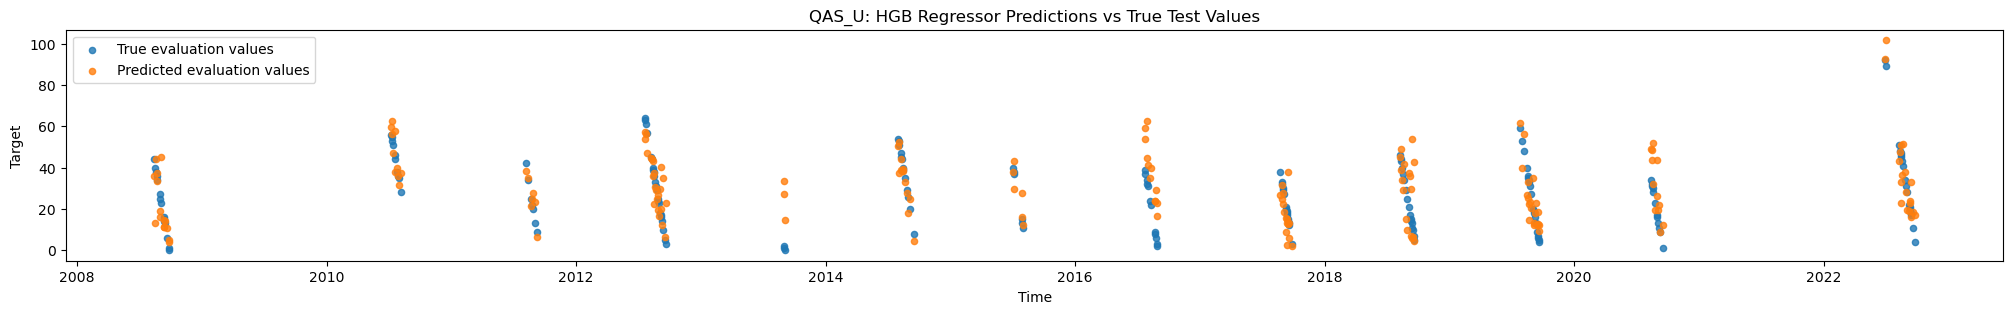

------------------------------------------------------------------------------------
station_names SCO_L
Number of observations at station 463
R^2 score on test set:  0.8527743757031141
MSE on test set:  13.184682365787772
MAE on test set 9.511978652519156


------------------------------------------------------------------------------------
station_names SCO_U
Number of observations at station 368
R^2 score on test set:  0.792717415051027
MSE on test set:  13.428181371173023
MAE on test set 9.865539860853385


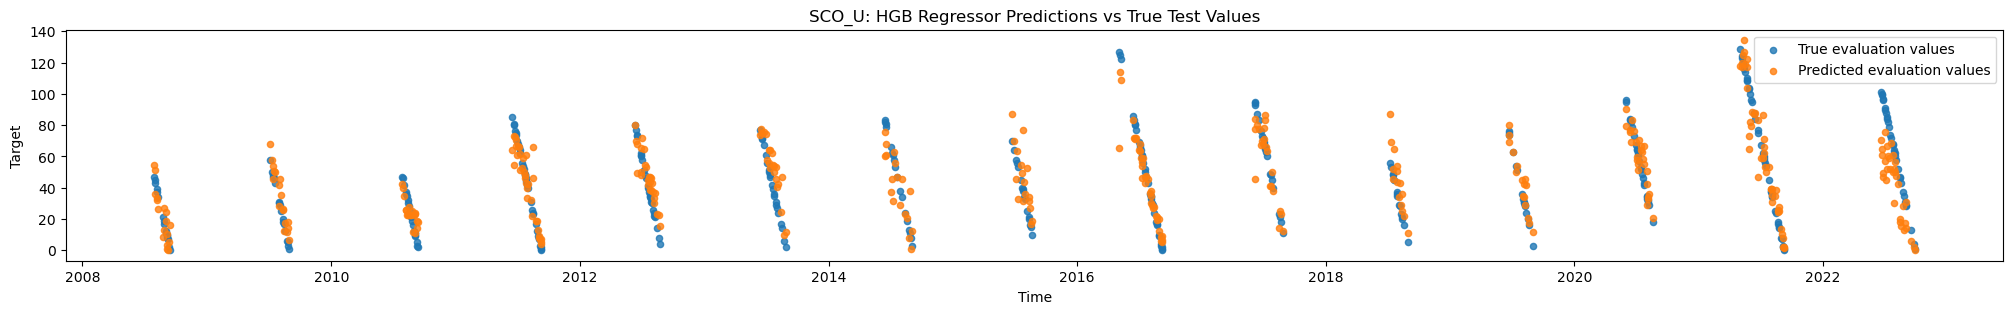

------------------------------------------------------------------------------------
station_names TAS_L
Number of observations at station 243
R^2 score on test set:  0.7327420510762361
MSE on test set:  18.144428353195618
MAE on test set 12.023382998655887


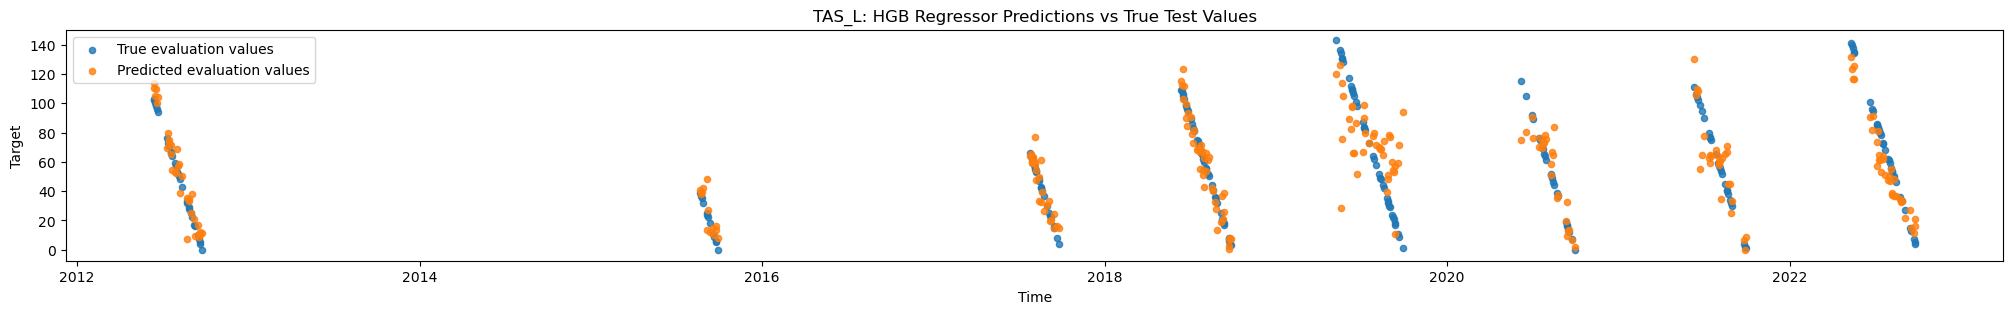

------------------------------------------------------------------------------------
station_names THU_L
Number of observations at station 179
R^2 score on test set:  0.6864571298878468
MSE on test set:  12.79440876014538
MAE on test set 9.02220271874778


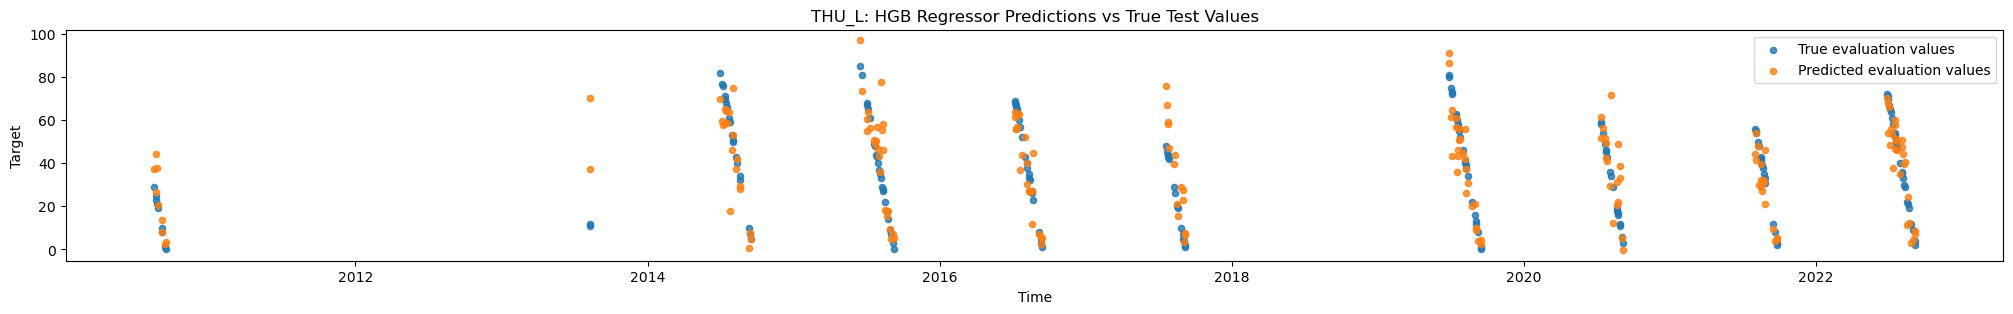

------------------------------------------------------------------------------------
station_names UPE_L
Number of observations at station 321
R^2 score on test set:  0.7805416999265097
MSE on test set:  14.128798938299811
MAE on test set 10.298640238017784


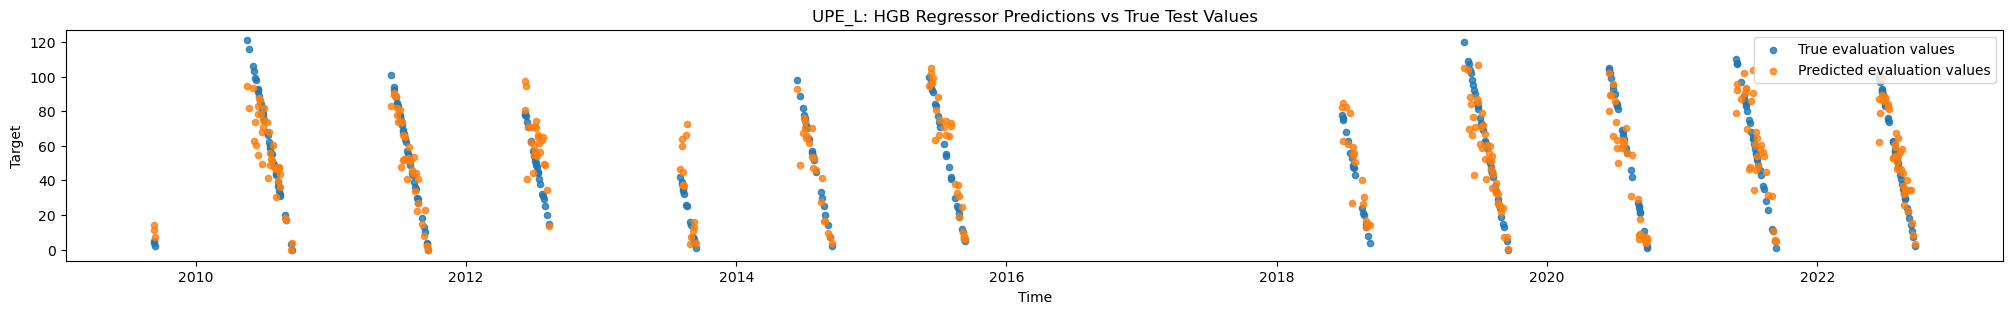

------------------------------------------------------------------------------------
station_names UPE_U
Number of observations at station 295
R^2 score on test set:  0.5968923452216555
MSE on test set:  17.698699769367312
MAE on test set 13.525076360531362


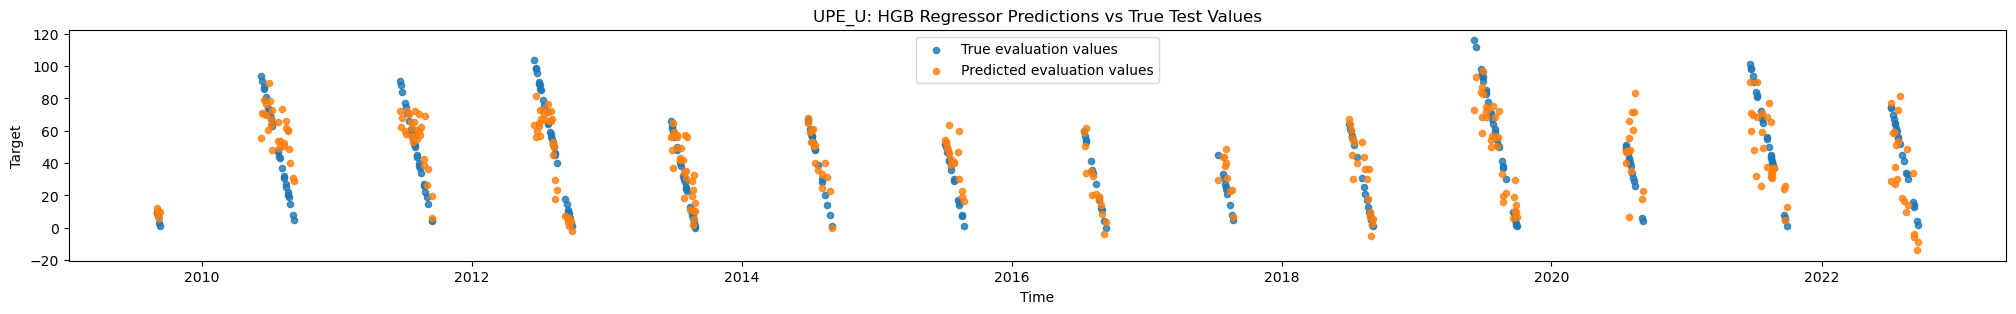

<module 'matplotlib.pyplot' from 'c:\\Users\\mabj16ac\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [20]:
# HistGB Regressor
model = HistGradientBoostingRegressor()

param_grid = {
    'min_samples_leaf': [1, 3, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_iter': [100, 500, 1000],
    'l2_regularization': [0, 0.1, 0.5]
}
param_grid = {
    'min_samples_leaf': [5], 'learning_rate': [0.1], 'max_iter': [500], 'l2_regularization': [0.1]
    }

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5, scoring='neg_mean_absolute_error')

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding R^2 score on the test set
print(grid_search.best_params_)
# Save the best model parameters as 'model' variable
hist_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = hist_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])

mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set: ", r2)
print(f"MSE on validation set: ", mse)
print(f'MAE on validation set: ', mae)

plot_learning_curve(best_estimator, "Learning Curve (HGB Regressor)", X_train, y_train, cv=cv)

station_performance_viz(df, X_train, X_test, y_train, y_test, 'HGB Regressor', hist_model)

# Shap Analysis

---------------------------------------------------------

## Preprocessing

In [62]:
def Shap_Filter(df, X_train):
    """
    Function to filter dates based on the ablation period and remove outliers.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data with columns 'stid', 'Year', and 'DayOfYear'.
    X_train (pd.DataFrame): Unused parameter in the current function context.
    period (str, optional): Currently unused parameter, defaults to 'start'.

    Returns:
    start, middle, end (Index): Index arrays representing the first, middle, and last weeks of the ablation period.
    """

    def remove_outliers(lst):
        q1, q3 = np.percentile(lst, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        return [x for x in lst if lower_bound <= x <= upper_bound]


    # Identification of first, middle and last weeks in ablation periods
    max_date, min_date = [], []
    stations = df['stid'].unique()
    for station in stations:
        station_df = df.loc[df['stid'] == station]
        years = station_df['Year'].unique()
        for year in years:
            year_df = station_df.loc[station_df['Year'] == year]
            local_max_date = year_df['DayOfYear'].max()
            local_min_date = year_df['DayOfYear'].min()
            max_date.append(local_max_date)
            min_date.append(local_min_date)


    print('Data Pre Outlier removal')

    max_date_avg = sum(max_date) / len(max_date)
    min_date_avg = sum(min_date) / len(min_date)
    mid_date_avg = (max_date_avg + min_date_avg) / 2 
    print('max date avg:', max_date_avg)
    print('min date avg:', min_date_avg)   

    # Ablation period outlier removal 
    print('Data Post Outlier removal')
    max_date = remove_outliers(max_date)
    min_date = remove_outliers(min_date)

    max_date_avg = sum(max_date) / len(max_date)
    min_date_avg = sum(min_date) / len(min_date)
    mid_date_avg = (max_date_avg + min_date_avg) / 2 
    print('max date avg:', max_date_avg)
    print('min date avg',min_date_avg)


    start_idx = df.loc[(df['DayOfYear'] >= min_date_avg) & (df['DayOfYear'] < min_date_avg + 7)].index
    print('first week sample:', df.loc[start_idx]['DayOfYear'].unique())
    middle_idx = df.loc[(df['DayOfYear'] >= mid_date_avg -4 ) & (df['DayOfYear'] < mid_date_avg + 3)].index
    print('middle week sample:', df.loc[middle_idx]['DayOfYear'].unique())
    end_idx = df.loc[(df['DayOfYear'] > max_date_avg -14 ) & (df['DayOfYear'] <= max_date_avg - 7)].index
    print('last week sample:', df.loc[end_idx]['DayOfYear'].unique())

    X_train_start, X_test_start = X_train.loc[X_train.index.intersection(start_idx)], X_test.loc[X_test.index.intersection(start_idx)]
    X_train_mid, X_test_mid = X_train.loc[X_train.index.intersection(middle_idx)], X_test.loc[X_test.index.intersection(middle_idx)]
    X_train_end, X_test_end = X_train.loc[X_train.index.intersection(end_idx)], X_test.loc[X_test.index.intersection(end_idx)]
    X_sets_out = [[X_train_start, X_test_start], [X_train_mid, X_test_mid], [X_train_end, X_test_end]] 
    return X_sets_out

X_sets = Shap_Filter(df, X_train) 
explainer = shap.Explainer(xgb_model)

Data Pre Outlier removal
max date avg: 259.48295454545456
min date avg: 168.1818181818182
Data Post Outlier removal
max date avg: 260.4161849710983
min date avg 168.1818181818182
first week sample: [169 170 171 172 173 174 175]
middle week sample: [211 212 213 214 215 216 217]
last week sample: [247 248 249 250 251 252 253]


## Visualization Function

In [63]:
def feature_importance(X_set, shap_values, max_display=None):
    X = X_set

    feature_names = X_set.columns

    mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

    sorted_feature_indices = np.argsort(mean_abs_shap_values)

    if max_display is not None:
        sorted_feature_indices = sorted_feature_indices[-max_display:]
    

    sorted_feature_names = feature_names[sorted_feature_indices]
    
    # Create a custom vertical summary plot with feature labels on the left
    plt.figure(figsize=(5, 5))
    bar_plot = plt.barh(sorted_feature_names, mean_abs_shap_values[sorted_feature_indices])
    plt.xlabel("Mean Shap Values (average impact on model output")
    plt.title("Mean Absolute SHAP Value")

    # Add labels to the bars
    for rect in bar_plot:
        width = rect.get_width()
        plt.text(width, rect.get_y() + rect.get_height() / 2.0, "{:.2f}".format(width), ha="left", va="center")

    plt.show()

## Shap Plots

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


[ 2  4 15 11 10  3  9 14  1 12  8 13 16  7  6  0  5]


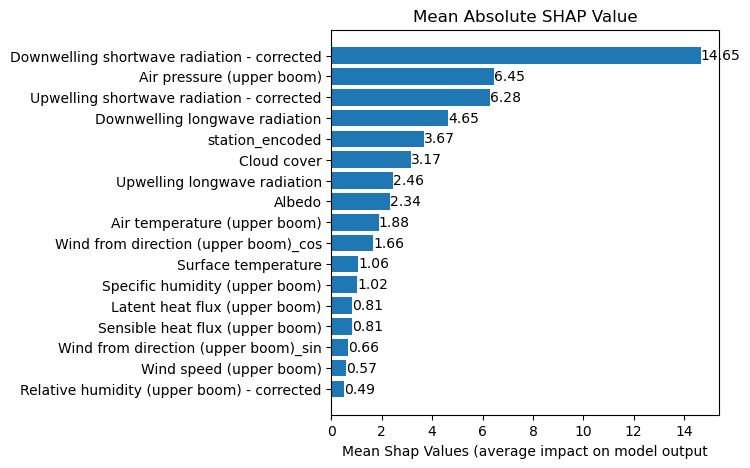

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [65]:
X_set = pd.concat([X_train, X_test])
X = X_set
shap_values = explainer(X_set)

feature_importance(X_set, shap_values)
shap.summary_plot(shap_values, X, plot_type="dot", plot_size = (8,4))

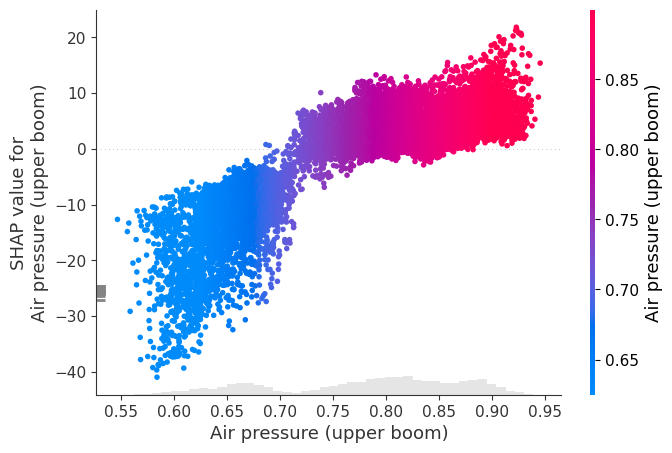

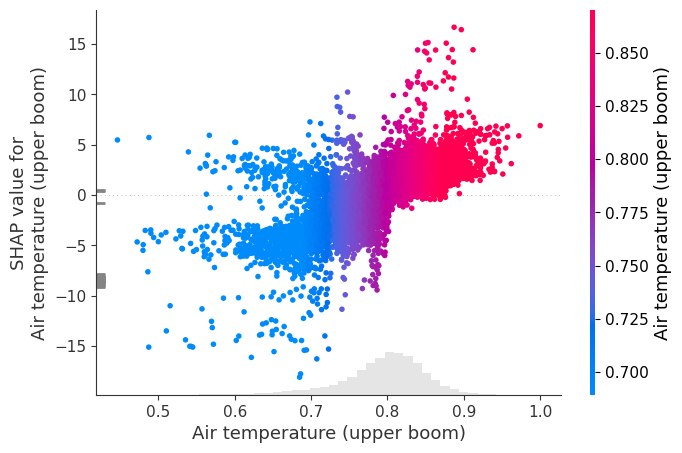

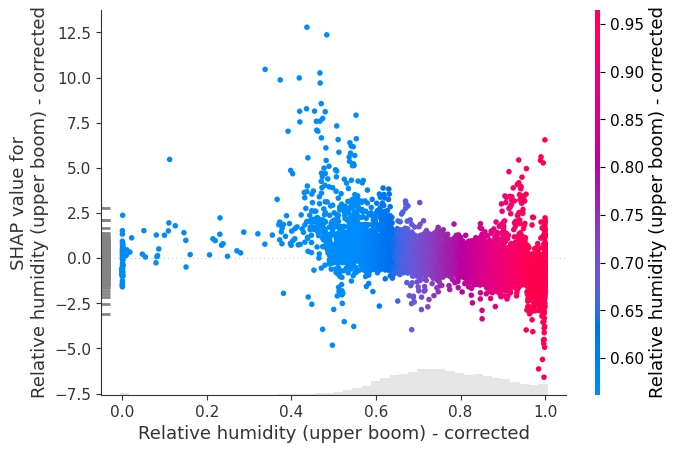

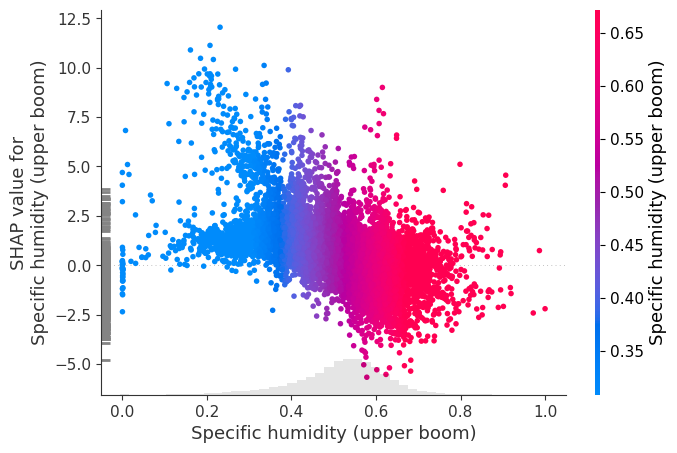

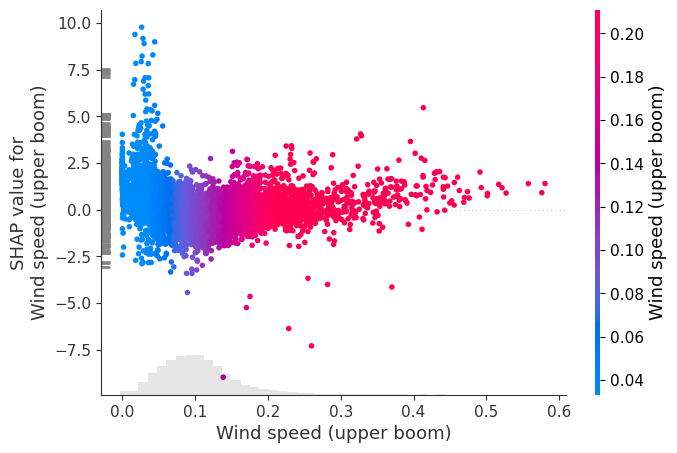

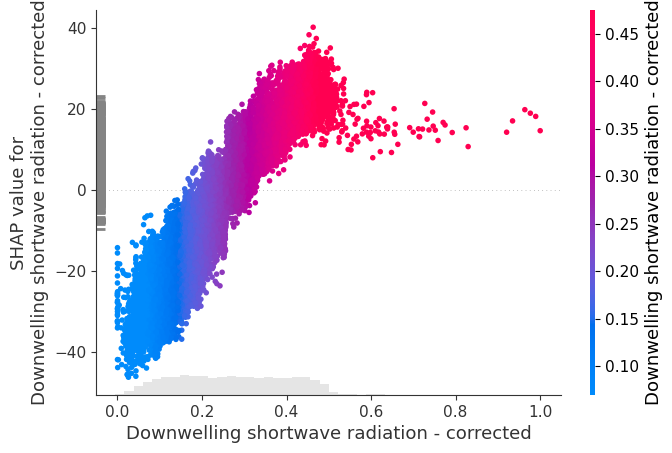

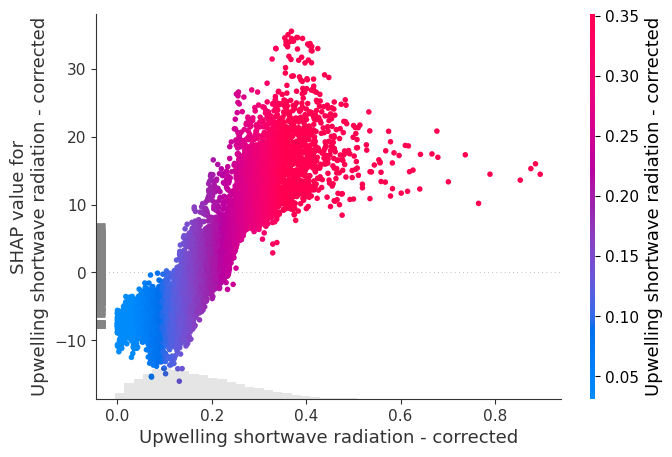

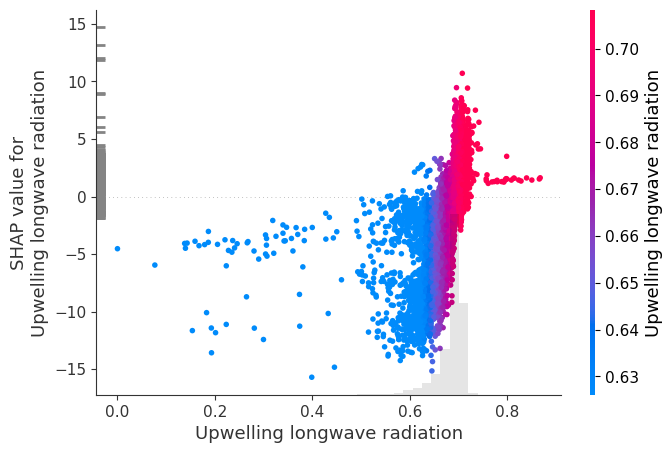

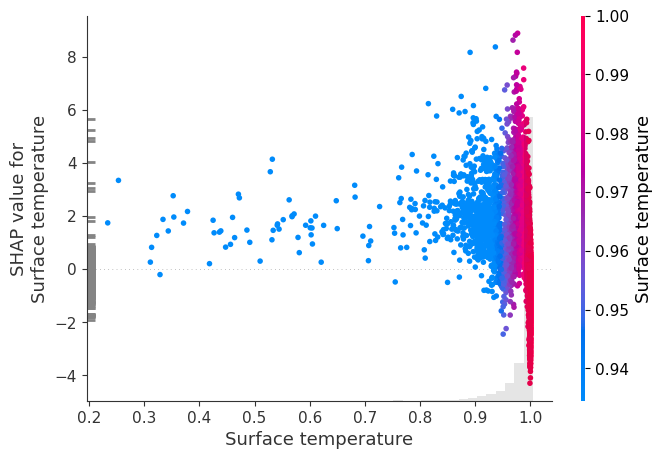

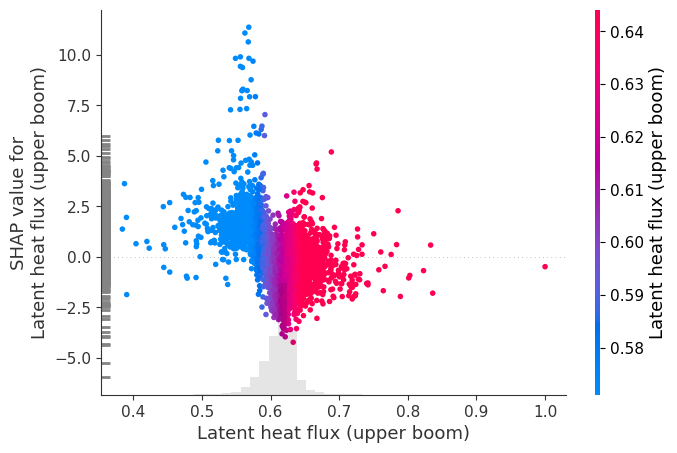

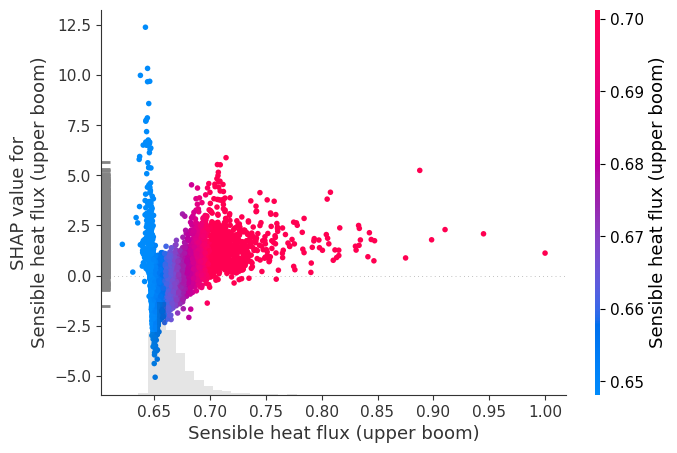

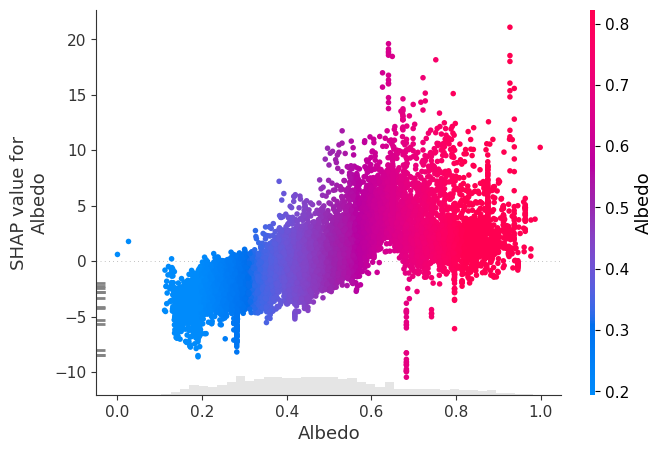

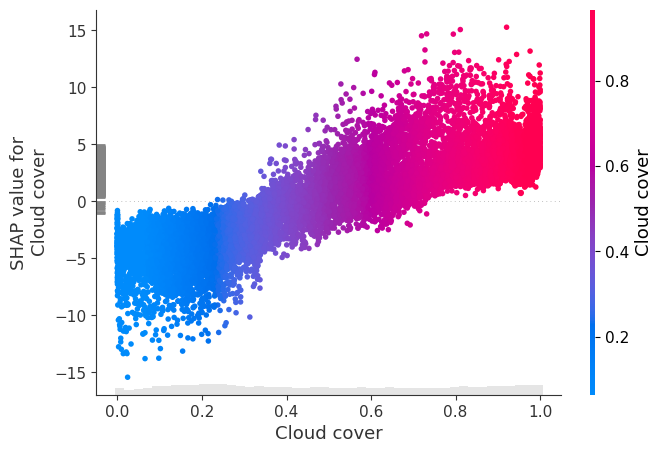

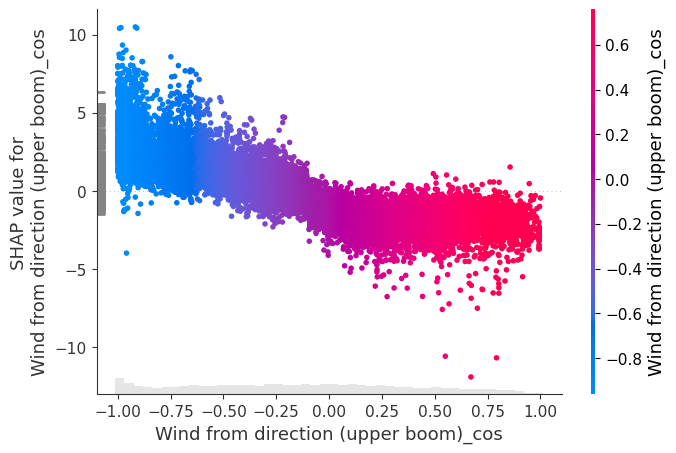

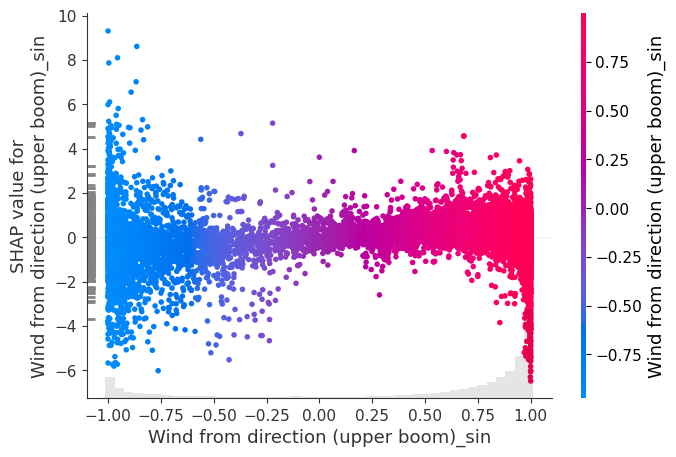

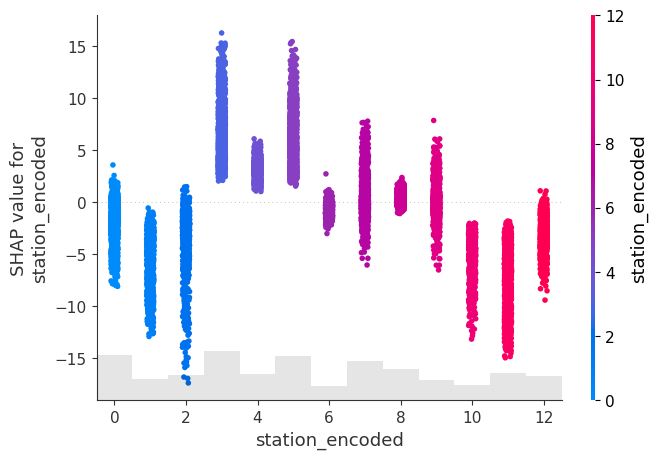

In [45]:
for i in range(17):
    shap.plots.scatter(shap_values[:,i], color=shap_values[:,i])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


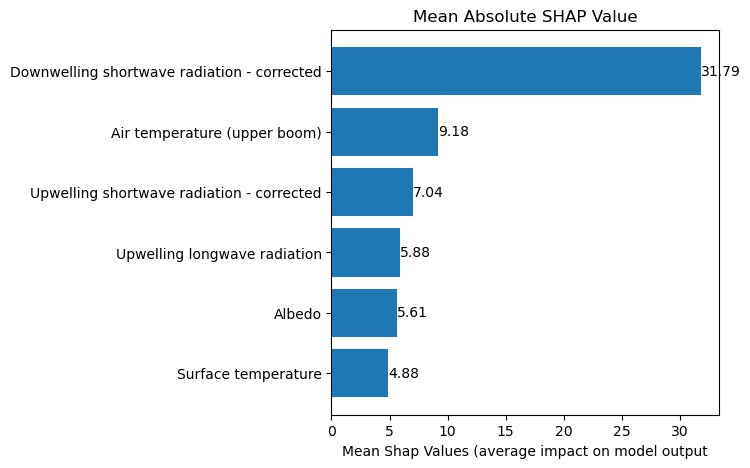

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


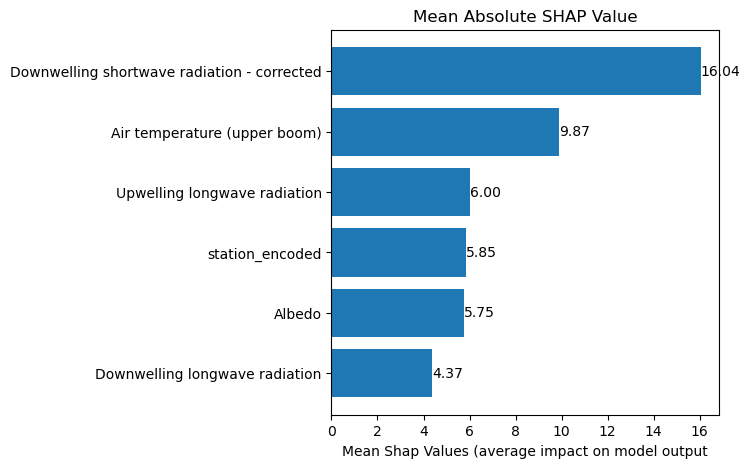

In [47]:
# Shap values of First, Middle, and Last weeks of ablation period  
for i in range(len(X_sets)):

    X_set_week = pd.concat([X_sets[i][0], X_sets[i][1]])
    #X_set = X_sets[i][1]
    X = X_set_week
    shap_values_week = explainer(X)

    positive_color = "#ca0020"
    negative_color = "#92c5de"

    feature_importance(X_set, shap_values_week, max_display=6)

In [ ]:
# Shap values by TTE

# Defining X_set
X_set = pd.concat([X_test, X_train])

# Grouping by TTE
X_set['time_to_event'] = df['time_to_event']
X_set = X_set.groupby('time_to_event').filter(lambda x: len(x) > 80)

grouped = X_set.groupby('time_to_event')

# Initialize an empty array to store average SHAP values for each day of the year
average_shap_values = []

# Iterating through each TTE and calculate average SHAP values
for day, group in grouped:
    shap_values_day = explainer(group.drop(columns=['time_to_event']))
    avg_shap_values = np.mean(shap_values_day.values, axis=0)
    average_shap_values.append(avg_shap_values)

# Converting the list of average SHAP values to a NumPy array
average_shap_values = np.array(average_shap_values)

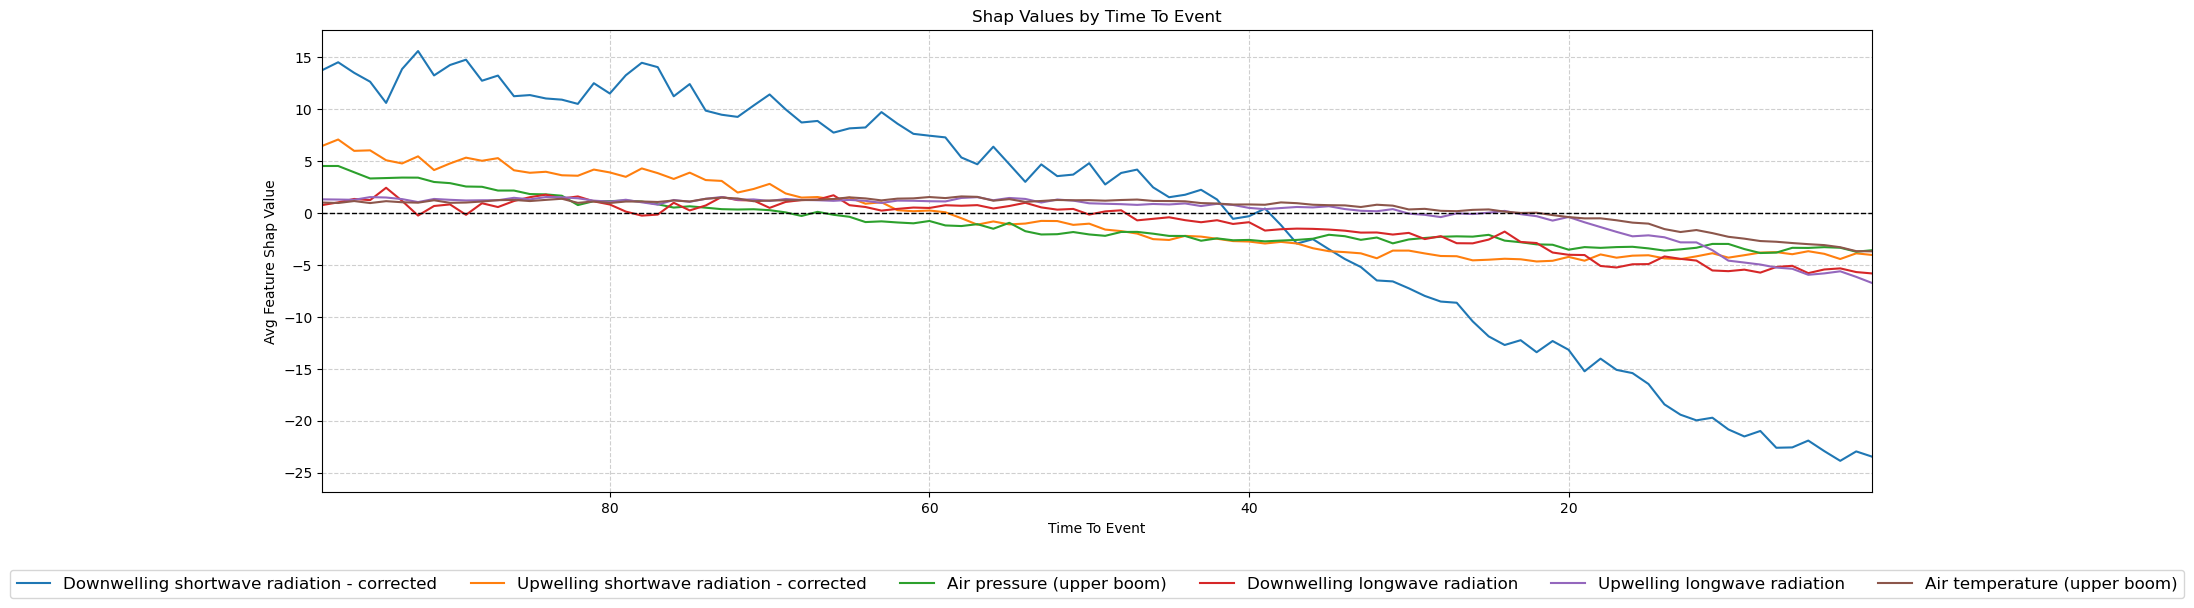

In [67]:
# Definition of data for visualization
days = grouped.mean().index.unique().to_list()
features_names = X_train.columns.to_list()
shap_df = pd.DataFrame(average_shap_values, columns=X_train.columns, index=days)

# Find the six columns with the highest average values
abs_df = shap_df.abs()
top_six_columns = abs_df.mean().nlargest(6).index

# Plot the DataFrame as a line plot with the index as the x-axis, and only the six columns with the highest average values
ax = shap_df[top_six_columns].plot(kind='line', figsize=(20, 6))
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Time To Event')
plt.ylabel('Avg Feature Shap Value')
plt.title('Shap Values by Time To Event')

ax.set_xlim(1, days[-1])
plt.gca().invert_xaxis()
ax.grid(True, linestyle='--', alpha=0.6)

# Move the legend underneath the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6, fontsize=12)

# Display the plot
plt.show()



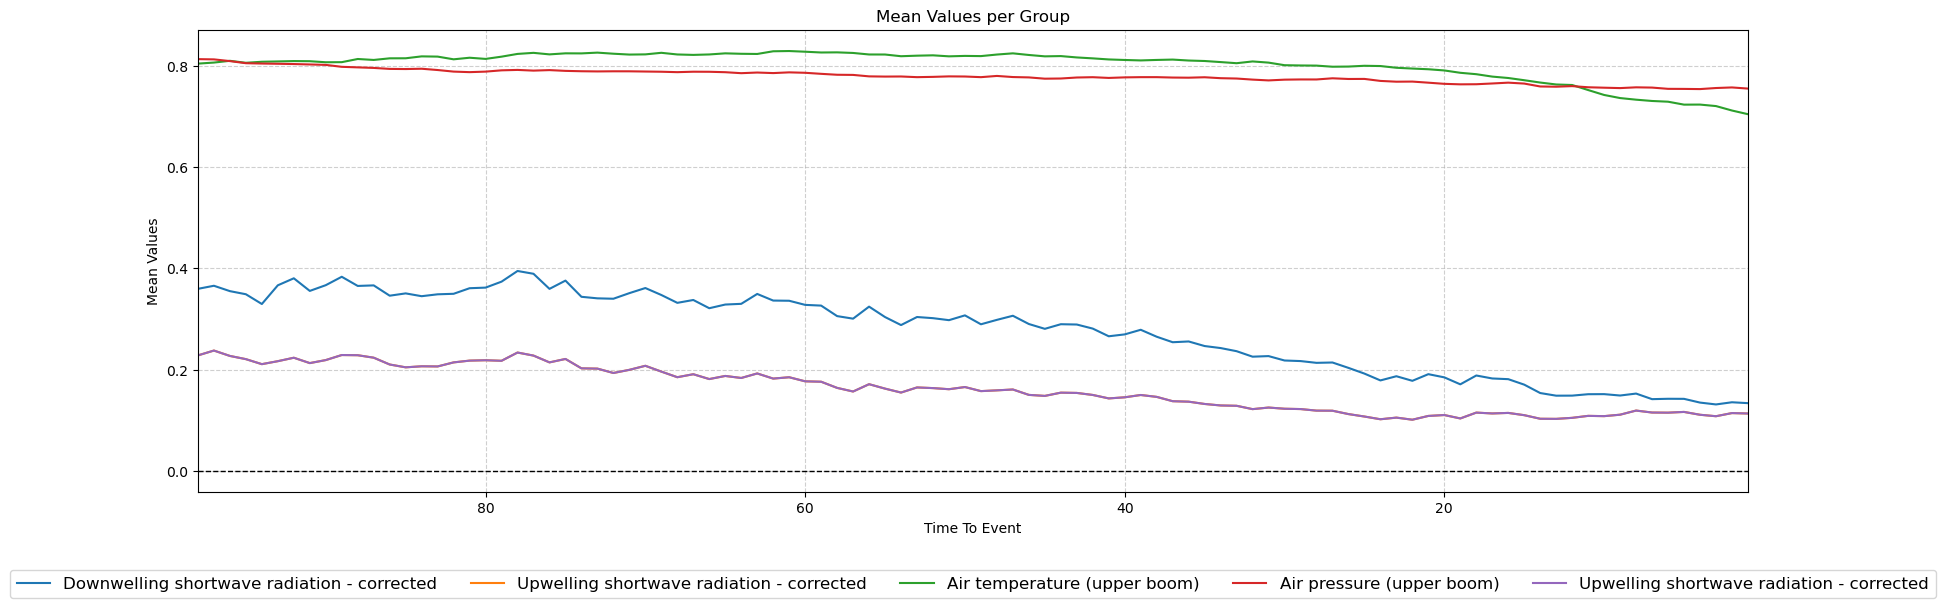

In [68]:
# Visualizing actual feature value development by TTE
df_group = df.groupby('time_to_event').filter(lambda x: len(x) > 80)

columns = ['Downwelling shortwave radiation - corrected','Upwelling shortwave radiation - corrected','Air temperature (upper boom)','Air pressure (upper boom)','Upwelling shortwave radiation - corrected']


grouped = df_group.groupby('time_to_event')[columns].mean()

# Plot
ax = grouped.plot(kind='line', figsize=(20, 6))
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Time To Event')
plt.ylabel('Mean Values')
plt.title('Mean Values per Group')

# Assuming that 'time_to_event' is a numerical column, the following line sets the limit of x-axis
ax.set_xlim(1, grouped.index.max())
plt.gca().invert_xaxis()
ax.grid(True, linestyle='--', alpha=0.6)

# Moving the legend underneath the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6, fontsize=12)

plt.show()


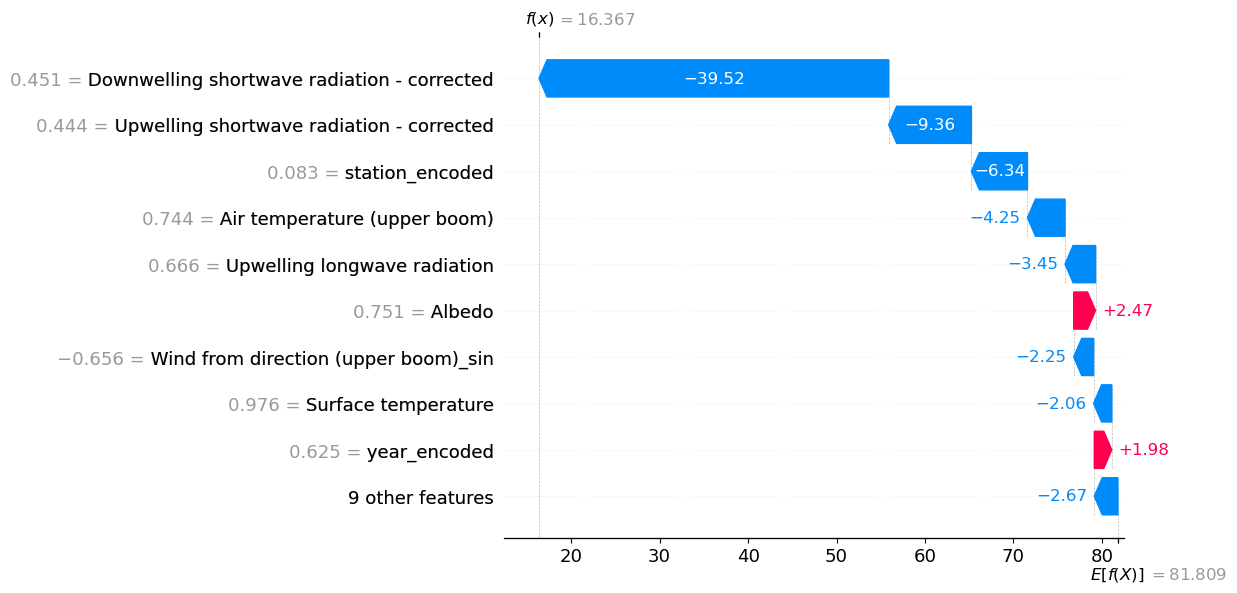

In [125]:
shap.plots.waterfall(shap_values[0])

# Survival analysis coxPHSurvival

In [72]:
df, features, target = preprocessing_melt(data, start_end='start',lags=False, exclude_nan=True)
X_train, X_test, y_train, y_test = custom_train_test_split(df, features, target)
X_train.drop('year_encoded', axis=1, inplace=True)
X_test.drop('year_encoded', axis=1, inplace=True)


In [79]:
# Splitting the data into features (covariates) and the target variables (event and time_to_event)
covariates = X_train  
event = y_train['event_True']
time_to_event = y_train['time_to_event']

# Creating structured arrays for the target variables
y = Surv.from_arrays(event, time_to_event)  # for training data
y_t = Surv.from_arrays(y_test['event_True'], y_test['time_to_event'])  # for test data

# Instantiating and fitting the Cox proportional hazards model
coxph = CoxPHSurvivalAnalysis(alpha=0.7)
coxph.fit(X_train, y)

# Convert test data to correct types for prediction
event_test = y_test['event_True'].astype('bool')
time_to_event_test = y_test['time_to_event']

# Predict with the test data and evaluate the model's performance
prediction = coxph.predict(X_test)
result = concordance_index_censored(event_test, time_to_event_test, prediction)
print(f'All Stations: {result}')

stations = df['stid'].unique() 

# Evaluate the model's performance for each station
for station in stations:
    # Get the indices that correspond to the current station
    station_index = df.loc[df['stid'] == station].index.intersection(y_test.index)

    time_to_event_test_station = time_to_event_test.loc[station_index]
    event_test_station = event_test.loc[station_index]
    X_test_station = X_test.loc[station_index]

    prediction_station = coxph.predict(X_test_station)
    station_result = concordance_index_censored(event_test_station, time_to_event_test_station, prediction_station)
    print(f'{station} c-index: {station_result[0]}')

# Plot feature importance based on coefficients
f1 = pd.DataFrame(data=coxph.coef_,
                  index=X_train.columns,
                  columns=['Importance']).sort_values(by='Importance',ascending=False)

ax = f1.sort_values('Importance').plot(kind='barh', title='Log Hazard Ratios')
ax.set_xlabel('Coefficient')
ax.set_ylabel('Feature')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

for i, v in enumerate(f1['Importance'].sort_values()):
    ax.text(v, i, str(round(v, 2)), color='black', ha='left', va='center')

plt.show()


All Stations: (0.7980411848519952, 5654690, 1431022, 0, 0)
KAN_L c-index: 0.7863471841152765
KPC_L c-index: 0.8366461190086804
MIT c-index: 0.7368730522725936
NUK_L c-index: 0.7937910504181827
NUK_U c-index: 0.7342111054060001
QAS_L c-index: 0.8112749532597552
QAS_U c-index: 0.6549375709421112
SCO_L c-index: 0.84058658394329
SCO_U c-index: 0.8571342237263553
TAS_L c-index: 0.8120164609053498
THU_L c-index: 0.8369958275382475
UPE_L c-index: 0.8268268268268268
UPE_U c-index: 0.7815185237357374


In [81]:
# Get the estimated survival functions for the test dataset
predicted_survival = coxph.predict_survival_function(X_test)
#display(predicted_survival)

plt.figure(figsize=(10, 6))
for i, surv_func in enumerate(predicted_survival[:10]):  # Change this to plot more or fewer curves
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Observation {i}")

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Predicted Survival Functions for Melt Season Start and End')
plt.legend(loc='upper right')
plt.show()

# Calculate time-dependent AUC
times = np.percentile(y_test['time_to_event'], np.linspace(5, 95, 5))
auc, mean_auc = cumulative_dynamic_auc(y, y_t, prediction, times)

# Plot time-dependent ROC curve
plt.figure(figsize=(10, 6))
plt.plot(times, auc, marker='o', color='blue')
plt.xlabel('Time')
plt.ylabel('AUC')
plt.title('Time-Dependent ROC Curve')
plt.show()


# Forest plot
def plot_forest_plot(data, y_labels, title='Forest Plot'):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.errorbar(data['HR'], np.arange(len(y_labels)), xerr=[data['HR'] - data['CI_lower'], data['CI_upper'] - data['HR']],
                fmt='o', color='black', capsize=3, elinewidth=1, markeredgewidth=1)
    ax.axvline(x=1, linestyle='--', color='gray', linewidth=1)
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Hazard Ratio (95% CI)')
    ax.set_title(title)
    ax.invert_yaxis()
    plt.show()

# Prepare the forest plot data
def get_confidence_intervals(model, alpha=0.05):
    se = np.sqrt(np.diag(model.variance_matrix_))
    z_score = -norm.ppf(alpha / 2)
    ci_lower = model.coef_ - z_score * se
    ci_upper = model.coef_ + z_score * se
    return ci_lower, ci_upper


# Plot time-dependent ROC curve
plt.figure(figsize=(10, 6))
plt.plot(times, auc, marker='o', color='blue')
plt.xlabel('Time')
plt.ylabel('AUC')
plt.title('Time-Dependent ROC Curve')
plt.show()
